## Applying Data Science techniques to maximize Likely to Book


Hypothesis: There are many factors that influence a customer’s likelihood of booking when they use our app.  If we understand these factors, we’ll be able to capitalize on that intent in various ways, and improve our conversion rate and revenue.


Assumptions: The timestamp are all in standlized. 


In [2]:
import warnings
warnings.simplefilter('ignore')

import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import auc, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler


In [123]:
#import gc
#gc.collect()

7

In [223]:
ctx = snowflake.connector.connect(
user='candidate1',
password='Welcome2HT',
account='hoteltonight',
warehouse ='adhoc',
database = 'candidate',
schema = 'public'
)
cs = ctx.cursor()
repeat= cs.execute("SELECT * from APP_SUVREPB_stp2").fetchall()

In [224]:
repeat = pd.DataFrame(repeat)
repeat.columns=['CUSTOMER_ID','APP_SESSION_SK','SESSION_START_TIMESTAMP','SESSION_END_TIMESTAMP','SESSION_DURATION_MINS','NTH_SESSION','APP_LAUNCH_CNT','HOTEL_DETAILS_CNT','INVENTORY_REQUEST_CNT','ORDER_SUMMARY_VIEWED_CNT','BOOKING_PURCHASED_CNT','PRIOR_SESSION_BOOK_CNT','NEXT_SESSION_BOOK_IND','SESSION_START_DT','EVER_PURCHASED_IND','FIRST_PURCHASE_DT','CUMULATIVE_SESSION_BOOK_CNT','HOURS_SINCE_LAST_SESSION','DESTINATION_CNT','DESTINATION_LIST','USER_MARKET_CNT','EVENT_CNT','MKTG_CHANNEL_NAME','PLATFORM_NAME','MAX_NUM_NIGHTS','MIN_NUM_NIGHTS','AVG_NUM_NIGHTS','MAX_DAYS_SEARCHED_IN_ADVANCE','MIN_DAYS_SEARCHED_IN_ADVANCE','AVG_DAYS_SEARCHED_IN_ADVANCE','MAX_PRICE','MIN_PRICE','AVG_PRICE','MAX_DISCOUNT','MIN_DISCOUNT','AVG_DISCOUNT','HOTEL_VIEW_CNT','DEAL_TYPE_DIST_CNT','STANDARD_DEAL_CNT','TARGET_DEAL_CNT','GEO_DEAL_CNT','HTPERK_DEAL_CNT','OTHER_DEAL_CNT','DESTINATION_COUNTRY','DESTINATION_METRO','DESTINATION_REGION','DISTANCE_MILE','CURRENT_COUNTRY','CURRENT_METRO','CURRENT_REGION','BOOKING_POSITION','BOOKING_PRICE','BOOKING_STRIKETHROUGH_PRICE','BOOKING_DISCOUNT','BOOKING_DEAL_TYPE']
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 200)         # Keep the output on one page
repeat.head()

,CUSTOMER_ID,APP_SESSION_SK,SESSION_START_TIMESTAMP,SESSION_END_TIMESTAMP,SESSION_DURATION_MINS,NTH_SESSION,APP_LAUNCH_CNT,HOTEL_DETAILS_CNT,INVENTORY_REQUEST_CNT,ORDER_SUMMARY_VIEWED_CNT,BOOKING_PURCHASED_CNT,PRIOR_SESSION_BOOK_CNT,NEXT_SESSION_BOOK_IND,SESSION_START_DT,EVER_PURCHASED_IND,FIRST_PURCHASE_DT,CUMULATIVE_SESSION_BOOK_CNT,HOURS_SINCE_LAST_SESSION,DESTINATION_CNT,DESTINATION_LIST,USER_MARKET_CNT,EVENT_CNT,MKTG_CHANNEL_NAME,PLATFORM_NAME,MAX_NUM_NIGHTS,MIN_NUM_NIGHTS,AVG_NUM_NIGHTS,MAX_DAYS_SEARCHED_IN_ADVANCE,MIN_DAYS_SEARCHED_IN_ADVANCE,AVG_DAYS_SEARCHED_IN_ADVANCE,MAX_PRICE,MIN_PRICE,AVG_PRICE,MAX_DISCOUNT,MIN_DISCOUNT,AVG_DISCOUNT,HOTEL_VIEW_CNT,DEAL_TYPE_DIST_CNT,STANDARD_DEAL_CNT,TARGET_DEAL_CNT,GEO_DEAL_CNT,HTPERK_DEAL_CNT,OTHER_DEAL_CNT,DESTINATION_COUNTRY,DESTINATION_METRO,DESTINATION_REGION,DISTANCE_MILE,CURRENT_COUNTRY,CURRENT_METRO,CURRENT_REGION,BOOKING_POSITION,BOOKING_PRICE,BOOKING_STRIKETHROUGH_PRICE,BOOKING_DISCOUNT,BOOKING_DEAL_TYPE
0,6707251,51749729,2017-10-19 11:52:26.255,2017-10-19 11:52:28.255,0,24,0,0,1,0,0,0.0,0.0,2017-10-19,0,NaT,5,0.0,1,53,1,1,CRM,Android App,1,1,1.000,0,0,0.000,179.00,54.00,96.86666,1.00,0.55,0.76600,15,2,15,15,15,15,15,UNITED STATES,"Palm Springs, CA",SoCal,0.000000,UNITED STATES,"Palm Springs, CA",SoCal,NaN,None,None,None,None
1,6707251,64187377,2017-10-23 07:48:34.704,2017-10-23 07:50:49.467,2,25,2,0,2,0,0,0.0,0.0,2017-10-23,0,NaT,5,92.0,1,53,1,2,CRM,Android App,1,1,1.000,0,-1,-0.483,450.00,40.00,111.96774,1.00,0.06,0.67903,24,4,31,31,31,31,31,UNITED STATES,"Palm Springs, CA",SoCal,0.114654,UNITED STATES,"Palm Springs, CA",SoCal,NaN,None,None,None,None
2,6707251,94822337,2017-10-23 12:17:54.467,2017-10-23 12:23:53.995,6,26,1,2,15,0,0,0.0,0.0,2017-10-23,0,NaT,5,5.0,9,"886,453,109,53,2,476,878,2222,885",1,9,CRM,Android App,2,1,1.811,4,0,3.247,450.00,52.00,150.65882,1.00,0.38,0.86411,79,3,85,85,85,85,85,UNITED STATES,"Palm Springs, CA",SoCal,116.733719,UNITED STATES,"Palm Springs, CA",SoCal,NaN,None,None,None,None
3,6707251,13041281,2017-10-23 20:23:50.633,2017-10-23 20:23:50.633,0,27,0,0,1,0,0,0.0,0.0,2017-10-23,0,NaT,5,8.0,1,878,1,1,CRM,Android App,2,2,2.000,4,4,4.000,85.00,75.00,80.66666,1.00,0.90,0.96666,3,1,3,3,3,3,3,UNITED STATES,"San Luis Obispo, CA",NORCAL_PACNW,259.497154,UNITED STATES,"Palm Springs, CA",SoCal,NaN,None,None,None,None
4,6707251,91707790,2017-10-31 14:25:38.041,2017-10-31 14:26:48.306,1,28,1,1,1,0,0,0.0,NaN,2017-10-31,0,NaT,5,186.0,1,2,1,1,CRM,Android App,1,1,1.000,0,0,0.000,700.00,85.00,170.81250,1.00,0.56,0.76250,16,3,16,16,16,16,16,UNITED STATES,"Los Angeles, CA",SoCal,422.818618,UNITED STATES,"Tucson, AZ",TEX_SW,NaN,None,None,None,None


In [104]:
# Gets the version
ctx = snowflake.connector.connect(
user='candidate1',
password='Welcome2HT',
account='hoteltonight',
warehouse ='adhoc',
database = 'candidate',
schema = 'public'
)
cs = ctx.cursor()
event= cs.execute("SELECT * from APP_EVENTS_stp1").fetchall()

In [105]:
event = pd.DataFrame(event)
event.columns=['CUSTOMER_ID','APP_SESSION_SK','EVENT_TYPE_LIST','POSITION_VIEW_CNT']
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 200)         # Keep the output on one page
event.head()

,CUSTOMER_ID,APP_SESSION_SK,EVENT_TYPE_LIST,POSITION_VIEW_CNT
0,5887350,162259965,"booking_purchased,hotel_details,inventory_requ...",2
1,6727848,106710578,"booking_purchased,hotel_details,inventory_requ...",5
2,4785669,178300831,"booking_purchased,hotel_details,inventory_requ...",3
3,257747,117246078,"booking_purchased,hotel_details,inventory_requ...",1
4,6324851,127717774,"booking_purchased,hotel_details,inventory_requ...",1


In [112]:
#new = event["EVENT_TYPE_LIST"].str.split(",", n = 1, expand = True) 
#event=event.drop(['booking_purchased','hotel_details'], axis=1)

In [99]:
#!/usr/bin/env python
import snowflake.connector

# Gets the version
ctx = snowflake.connector.connect(
user='candidate1',
password='Welcome2HT',
account='hoteltonight',
warehouse ='adhoc',
database = 'candidate',
schema = 'public'
)
cs = ctx.cursor()
train= cs.execute("SELECT * from APP_SESSION_FACT_stp2 limit 500000").fetchall()

In [100]:
import pandas as pd

train = pd.DataFrame(train)
train.columns=['CUSTOMER_ID',	'APP_SESSION_SK',	'SESSION_START_TIMESTAMP',	'SESSION_END_TIMESTAMP',	'SESSION_DURATION_MINS',	'NTH_SESSION',	'APP_LAUNCH_CNT',	'HOTEL_DETAILS_CNT',	'INVENTORY_REQUEST_CNT',	'ORDER_SUMMARY_VIEWED_CNT',	'BOOKING_PURCHASED_CNT',	'PRIOR_SESSION_BOOK_CNT',	'NEXT_SESSION_BOOK_IND',	'SESSION_START_DT',	'EVER_PURCHASED_IND',	'FIRST_PURCHASE_DT',	'CUMULATIVE_SESSION_BOOK_CNT',	'HOUR_SINCE_LAST_SESSION',	'DESTINATION_CNT',	'DESTINATION_LIST',	'USER_MARKET_CNT',	'EVENT_CNT',	'MKTG_CHANNEL_NAME',	'PLATFORM_NAME',	'MAX_NUM_NIGHTS',	'MIN_NUM_NIGHTS',	'AVG_NUM_NIGHTS',	'MAX_DAYS_SEARCHED_IN_ADVANCE',	'MIN_DAYS_SEARCHED_IN_ADVANCE',	'AVG_DAYS_SEARCHED_IN_ADVANCE',	'MAX_PRICE',	'MIN_PRICE',	'AVG_PRICE',	'MAX_DISCOUNT',	'MIN_DISCOUNT',	'AVG_DISCOUNT',	'HOTEL_VIEW_CNT',	'DEAL_TYPE_DIST_CNT',	'STANDARD_DEAL_CNT',	'TARGET_DEAL_CNT',	'GEO_DEAL_CNT',	'HTPERK_DEAL_CNT',	'DESTINATION_COUNTRY',	'DESTINATION_METRO',	'DESTINATION_REGION',	'AVG_DISTANCE_MILE',	'CURRENT_COUNTRY',	'CURRENT_METRO',	'CURRENT_REGION',	'BOOKING_POSITION',	'BOOKING_PRICE',	'BOOKING_DISCOUNT']
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 200)         # Keep the output on one page
train.head()

,CUSTOMER_ID,APP_SESSION_SK,SESSION_START_TIMESTAMP,SESSION_END_TIMESTAMP,SESSION_DURATION_MINS,NTH_SESSION,APP_LAUNCH_CNT,HOTEL_DETAILS_CNT,INVENTORY_REQUEST_CNT,ORDER_SUMMARY_VIEWED_CNT,BOOKING_PURCHASED_CNT,PRIOR_SESSION_BOOK_CNT,NEXT_SESSION_BOOK_IND,SESSION_START_DT,EVER_PURCHASED_IND,FIRST_PURCHASE_DT,CUMULATIVE_SESSION_BOOK_CNT,HOUR_SINCE_LAST_SESSION,DESTINATION_CNT,DESTINATION_LIST,USER_MARKET_CNT,EVENT_CNT,MKTG_CHANNEL_NAME,PLATFORM_NAME,MAX_NUM_NIGHTS,MIN_NUM_NIGHTS,AVG_NUM_NIGHTS,MAX_DAYS_SEARCHED_IN_ADVANCE,MIN_DAYS_SEARCHED_IN_ADVANCE,AVG_DAYS_SEARCHED_IN_ADVANCE,MAX_PRICE,MIN_PRICE,AVG_PRICE,MAX_DISCOUNT,MIN_DISCOUNT,AVG_DISCOUNT,HOTEL_VIEW_CNT,DEAL_TYPE_DIST_CNT,STANDARD_DEAL_CNT,TARGET_DEAL_CNT,GEO_DEAL_CNT,HTPERK_DEAL_CNT,DESTINATION_COUNTRY,DESTINATION_METRO,DESTINATION_REGION,AVG_DISTANCE_MILE,CURRENT_COUNTRY,CURRENT_METRO,CURRENT_REGION,BOOKING_POSITION,BOOKING_PRICE,BOOKING_DISCOUNT
0,4085040,120155875,2017-10-30 17:11:55.713,2017-10-30 17:13:47.360,2,436,1,1,3,0,0,0.0,0.0,2017-10-30,0,NaT,1,22.0,2,"1,115",1,3,CRM,Ios App,1,1,1.000,4,3,3.282,739.00,96.00,219.10256,1.00,0.46,0.80256,31,3,22,3,0,14,UNITED STATES,"San Francisco, CA",NORCAL_PACNW,229.405520,UNITED STATES,"Santa Monica, CA",SoCal,7.179,219.10256,1.27
1,4085040,225680293,2017-10-30 18:11:51.763,2017-10-30 18:24:11.066,13,437,3,3,4,0,0,0.0,0.0,2017-10-30,0,NaT,1,1.0,2,"1,115",1,4,CRM,Ios App,1,1,1.000,4,3,3.698,739.00,88.00,204.01886,1.00,0.38,0.77509,32,3,22,3,0,28,UNITED STATES,"Sonoma County, CA",NORCAL_PACNW,226.217652,UNITED STATES,"Santa Monica, CA",SoCal,7.320,204.01886,1.21
2,4085040,118252851,2017-10-30 19:40:29.164,2017-10-30 19:40:36.921,0,438,1,0,1,0,0,0.0,NaN,2017-10-30,0,NaT,1,1.0,1,1,1,1,CRM,Ios App,1,1,1.000,3,3,3.000,739.00,96.00,195.06250,1.00,0.46,0.66312,16,3,1,2,0,13,UNITED STATES,"San Francisco, CA",NORCAL_PACNW,218.640945,UNITED STATES,"Santa Monica, CA",SoCal,8.500,195.06250,0.84
3,4085044,199699984,2017-10-01 12:55:39.341,2017-10-01 13:09:14.367,14,24,1,2,8,0,0,NaN,0.0,2017-10-01,0,NaT,0,NaN,2,"439,1",1,5,Organic,Ios App,3,1,2.184,5,0,2.960,799.00,67.00,201.60526,1.00,0.31,0.77263,46,2,42,0,0,34,UNITED STATES,"Chicago, IL",MidWest,2181.324090,UNITED STATES,"New York City, NJ",NYC,8.105,201.60526,0.85
4,4085074,229444767,2017-10-31 01:59:46.545,2017-10-31 02:07:58.960,8,7,2,2,3,0,0,NaN,0.0,2017-10-31,0,NaT,0,NaN,2,"212,639",1,3,Organic,Ios App,1,1,1.000,0,0,0.000,739.00,65.00,141.95652,1.00,0.50,0.86347,31,4,33,8,2,3,UNITED STATES,"Sacramento, CA",NORCAL_PACNW,17.679192,UNITED STATES,"Sacramento, CA",NORCAL_PACNW,8.173,141.95652,1.58


We've done some basic QA of the data, such as checking whether there are duplicates . Some assumptions such as the data is a Representative dataset.

In [101]:
train[['AVG_NUM_NIGHTS','AVG_DAYS_SEARCHED_IN_ADVANCE','MAX_PRICE','MIN_PRICE','AVG_PRICE','MAX_DISCOUNT','MIN_DISCOUNT' ,'AVG_DISCOUNT','BOOKING_PRICE']]=train[['AVG_NUM_NIGHTS','AVG_DAYS_SEARCHED_IN_ADVANCE','MAX_PRICE','MIN_PRICE','AVG_PRICE','MAX_DISCOUNT','MIN_DISCOUNT' ,'AVG_DISCOUNT','BOOKING_PRICE']].apply(pd.to_numeric)

### Exploratory analysis

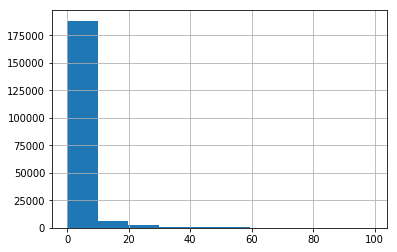

In [292]:
train.loc[train['AVG_DAYS_SEARCHED_IN_ADVANCE']>0]['AVG_DAYS_SEARCHED_IN_ADVANCE'].hist()

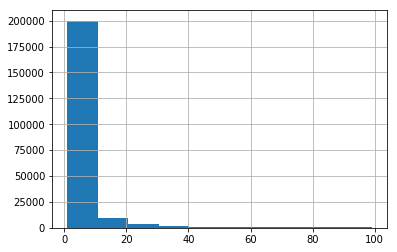

In [102]:
train.loc[train['MAX_DAYS_SEARCHED_IN_ADVANCE']>0]['MAX_DAYS_SEARCHED_IN_ADVANCE'].hist()

In [135]:
train['BOOKING_PURCHASED_IND'] = 0
train.loc[train['BOOKING_PURCHASED_CNT'] >0, 'BOOKING_PURCHASED_IND'] = 1 
train['BOOKING_PURCHASED_IND'].value_counts()

0    471038
1     28962
Name: BOOKING_PURCHASED_IND, dtype: int64

In [103]:
train.sample(20)

,CUSTOMER_ID,APP_SESSION_SK,SESSION_START_TIMESTAMP,SESSION_END_TIMESTAMP,SESSION_DURATION_MINS,NTH_SESSION,APP_LAUNCH_CNT,HOTEL_DETAILS_CNT,INVENTORY_REQUEST_CNT,ORDER_SUMMARY_VIEWED_CNT,BOOKING_PURCHASED_CNT,PRIOR_SESSION_BOOK_CNT,NEXT_SESSION_BOOK_IND,SESSION_START_DT,EVER_PURCHASED_IND,FIRST_PURCHASE_DT,CUMULATIVE_SESSION_BOOK_CNT,HOUR_SINCE_LAST_SESSION,DESTINATION_CNT,DESTINATION_LIST,USER_MARKET_CNT,EVENT_CNT,MKTG_CHANNEL_NAME,PLATFORM_NAME,MAX_NUM_NIGHTS,MIN_NUM_NIGHTS,AVG_NUM_NIGHTS,MAX_DAYS_SEARCHED_IN_ADVANCE,MIN_DAYS_SEARCHED_IN_ADVANCE,AVG_DAYS_SEARCHED_IN_ADVANCE,MAX_PRICE,MIN_PRICE,AVG_PRICE,MAX_DISCOUNT,MIN_DISCOUNT,AVG_DISCOUNT,HOTEL_VIEW_CNT,DEAL_TYPE_DIST_CNT,STANDARD_DEAL_CNT,TARGET_DEAL_CNT,GEO_DEAL_CNT,HTPERK_DEAL_CNT,DESTINATION_COUNTRY,DESTINATION_METRO,DESTINATION_REGION,AVG_DISTANCE_MILE,CURRENT_COUNTRY,CURRENT_METRO,CURRENT_REGION,BOOKING_POSITION,BOOKING_PRICE,BOOKING_DISCOUNT
60412,4105597,37367070,2017-10-12 18:37:23.279,2017-10-12 18:38:53.303,1,31,1,1,1,2,0,0.0,0.0,2017-10-12,0,NaT,0,1.0,1,250,1,1,Organic,Ios App,1,1,1.000,3,3,3.000,186.0,54.0,102.66666,1.00,0.87,0.98400,15,2,13,0,0,2,UNITED STATES,"Columbus, OH",MidWest,86.004535,UNITED STATES,"Cleveland, OH",MidWest,8.000,102.66666,5.58
4149,4093412,137031228,2017-10-27 21:59:29.794,2017-10-27 22:01:28.468,2,29,1,2,3,5,1,0.0,0.0,2017-10-27,1,2017-10-27 21:59:29.794,0,20.0,1,122,1,3,Organic,Ios App,1,1,1.000,1,0,0.210,415.0,0.0,165.31578,1.00,0.00,0.86894,14,2,17,2,0,0,UNITED STATES,"Ventura County, CA",SoCal,0.000000,UNITED STATES,"Ventura County, CA",SoCal,4.526,165.31578,1.66
391952,4208789,204498382,2017-10-18 19:58:54.166,2017-10-18 19:58:54.929,0,63,1,0,1,0,0,0.0,0.0,2017-10-18,0,NaT,0,93.0,1,1535,1,1,Organic,Ios App,1,1,1.000,0,0,0.000,352.0,108.0,196.93333,1.00,0.57,0.90200,15,2,13,0,2,0,UNITED STATES,"Newport, RI",NE_MA,0.000000,UNITED STATES,"Newport, RI",NE_MA,8.000,196.93333,1.42
389836,1624312,209701294,2017-10-16 21:26:58.223,2017-10-16 21:40:33.963,14,65,6,9,3,5,1,NaN,0.0,2017-10-16,1,2017-10-16 21:26:58.223,0,NaN,1,840,1,3,Organic,Ios App,1,1,1.000,0,0,0.000,340.0,99.0,203.35555,1.00,0.61,0.88266,16,2,37,0,0,8,UNITED STATES,"Denver, CO",MidWest,0.000000,UNITED STATES,"Denver, CO",MidWest,8.000,203.35555,1.65
198686,5951476,40453415,2017-10-05 17:42:29.775,2017-10-05 17:42:52.214,0,159,1,1,1,0,0,NaN,0.0,2017-10-05,0,NaT,0,NaN,1,1538,1,1,Display Ads,Ios App,1,1,1.000,0,0,0.000,169.0,59.0,113.20000,1.00,0.76,0.96733,15,3,13,0,1,1,UNITED STATES,"Chicago, IL",MidWest,0.000000,UNITED STATES,"Chicago, IL",MidWest,8.000,113.20000,4.64
286139,5300386,45660560,2017-10-19 02:05:49.879,2017-10-19 02:12:07.438,7,92,2,1,4,2,1,0.0,0.0,2017-10-19,1,2017-10-19 02:05:49.879,0,2.0,1,253,1,4,Organic,Ios App,1,1,1.000,4,4,4.000,294.0,104.0,148.56896,1.00,0.52,0.93344,25,3,41,10,0,7,UNITED STATES,"Long Island, NY",NYC,148.742862,UNITED STATES,"Portland (ME), ME",NE_MA,7.775,148.56896,2.46
281137,4429345,209573875,2017-10-23 01:26:54.514,2017-10-23 01:32:07.707,6,121,3,0,5,0,0,NaN,0.0,2017-10-23,0,NaT,0,NaN,3,"1766,71,209",1,5,Organic,Ios App,1,1,1.000,5,0,1.940,393.0,75.0,153.83582,1.00,0.30,0.89328,29,3,54,0,2,11,UNITED STATES,"Santa Rosa, CA",NORCAL_PACNW,33.627075,UNITED STATES,"Santa Rosa, CA",NORCAL_PACNW,7.283,153.83582,1.38
131819,6502056,27177395,2017-10-23 01:22:38.735,2017-10-23 01:22:39.559,0,24,1,0,1,0,0,0.0,0.0,2017-10-23,0,NaT,0,5.0,1,2907,1,1,Organic,Ios App,3,3,3.000,19,19,19.000,303.0,94.0,200.00000,0.97,0.53,0.79090,11,2,5,6,0,0,UNITED STATES,"Las Vegas, NV",TEX_SW,123.568969,UNITED STATES,"San Diego, CA",SoCal,6.000,200.00000,0.79
361386,1592458,181106719,2017-10-31 16:12:26.704,2017-10-31 16:12:27.896,0,152,1,0,1,0,0,1.0,NaN,2017-10-31,0,NaT,1,324.0,1,2461,1,1,Organic,Ios App,1,1,1.000,0,0,0.000,220.0,65.0,126.16666,1.00,0.58,0.93916,12,2,10,0,0,2,UNITED STATES,"Delano, MN",MidWest,0.000000,UNITED STATES,"Delano, MN",MidWest,6.500,126.16666,2.99
59237,6352383,77372753,2017-10-07 19:30:51.580,2017-10-07 19:38:04.675,8,10,3,1,4,0,0,

In [299]:
train.loc[train['AVG_DAYS_SEARCHED_IN_ADVANCE']>0].groupby('BOOKING_PURCHASED_IND')['AVG_DAYS_SEARCHED_IN_ADVANCE'].describe()

,count,mean,std,min,25%,50%,75%,max
BOOKING_PURCHASED_IND,,,,,,,,
0,187893.0,3.587144,6.443313,0.005,1.000,2.000,4.0,99.0
1,11626.0,2.287720,3.664850,0.008,0.835,1.111,3.0,77.0


In [300]:
train.groupby('BOOKING_PURCHASED_IND')['APP_LAUNCH_CNT'].describe()

,count,mean,std,min,25%,50%,75%,max
BOOKING_PURCHASED_IND,,,,,,,,
0,427986.0,1.701553,3.227999,0.0,1.0,1.0,2.0,1785.0
1,35758.0,4.030091,4.093072,0.0,1.0,3.0,5.0,79.0


In [318]:
train.groupby('BOOKING_PURCHASED_IND')['AVG_PRICE'].mean()

BOOKING_PURCHASED_IND
0    435.005231
1    288.952170
Name: AVG_PRICE, dtype: float64

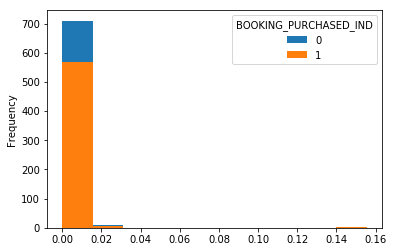

In [12]:
HOURS_SINCE_LAST_SESSION= train.groupby('BOOKING_PURCHASED_IND')['HOURS_SINCE_LAST_SESSION'].value_counts(normalize=True).unstack()
HOURS_SINCE_LAST_SESSION.T.plot(kind='hist')

In [16]:
train.groupby('BOOKING_PURCHASED_IND')['PLATFORM_NAME'].value_counts(normalize=True).unstack()

PLATFORM_NAME,,Android App,Ios App,Mobile Web
BOOKING_PURCHASED_IND,,,,
0,0.077000,0.14536,0.755915,0.021726
1,0.015202,0.13024,0.738171,0.116387


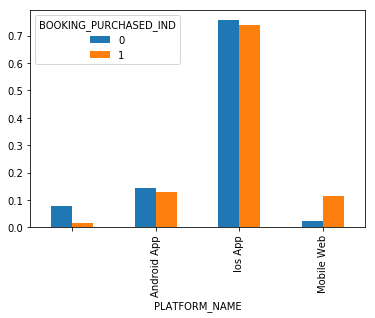

In [15]:
train.groupby('BOOKING_PURCHASED_IND')['PLATFORM_NAME'].value_counts(normalize=True).unstack().T.plot(kind='bar')

In [ ]:
HOURS_SINCE_LAST_SESSION= train.loc[('NEXT_SESSION_BOOK_IND'==1) &]'BOOKING_PURCHASED_IND')['HOURS_SINCE_LAST_SESSION'].value_counts(normalize=True).unstack()
HOURS_SINCE_LAST_SESSION.T.plot(kind='hist')

train.loc[train['AVG_DAYS_SEARCHED_IN_ADVANCE']>0]['AVG_DAYS_SEARCHED_IN_ADVANCE'].hist()

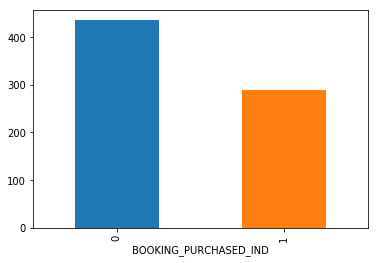

In [317]:
train.groupby('BOOKING_PURCHASED_IND')['AVG_PRICE'].mean().plot(kind='bar')

In [105]:
train['day_of_week'] = train['SESSION_START_TIMESTAMP'].apply(lambda x: x.weekday_name)
train['time_of_day'] = train['SESSION_START_TIMESTAMP'].apply(lambda x: x.hour)

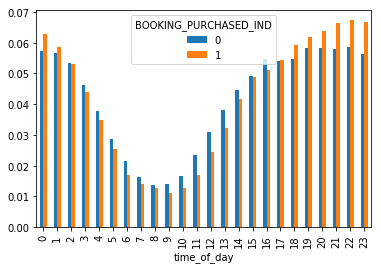

In [136]:
time_of_day= train.groupby('BOOKING_PURCHASED_IND')['time_of_day'].value_counts(normalize=True).unstack()
time_of_day.T.plot(kind='bar')


In [137]:
time_of_day

time_of_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
BOOKING_PURCHASED_IND,,,,,,,,,,,,,,,,,,,,,,,,
0,0.057095,0.056639,0.053327,0.046047,0.037776,0.028624,0.021631,0.016145,0.013787,0.014126,0.016472,0.023433,0.030777,0.038027,0.044436,0.049264,0.054514,0.053851,0.054630,0.058199,0.058178,0.057957,0.058675,0.056390
1,0.062737,0.058421,0.053000,0.043954,0.034770,0.025516,0.016815,0.013949,0.012741,0.011256,0.012672,0.016988,0.024480,0.032318,0.041572,0.048823,0.051067,0.054382,0.059077,0.061632,0.063704,0.066294,0.067295,0.066535


In [138]:
day_of_week= train.groupby('BOOKING_PURCHASED_IND')['day_of_week'].value_counts(normalize=True).unstack()
day_of_week

day_of_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
BOOKING_PURCHASED_IND,,,,,,,
0,0.141218,0.148158,0.140176,0.143691,0.132242,0.160601,0.133915
1,0.145708,0.157827,0.136420,0.150128,0.133796,0.154824,0.121297


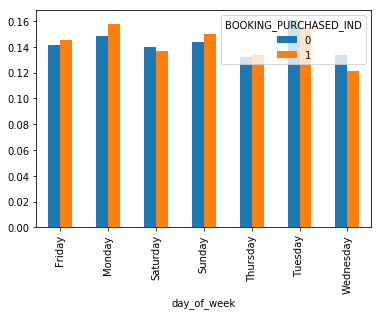

In [139]:
day_of_week.T.plot(kind='bar')

In [20]:
train['AVG_DAYS_SEARCHED_IN_ADVANCE'].mean()

1.145270688

In [47]:
train.shape

(500000, 52)

In [106]:
train = train[train['EVENT_CNT']>0]
train.shape

(500000, 54)

In [54]:
train = train.drop(train[train.NEXT_SESSION_BOOK_IND.isnull()].index)
train.shape

(382698, 54)

In [17]:
a=train.groupby('BOOKING_PURCHASED_IND')['DESTINATION_COUNTRY'].value_counts(normalize=True).unstack()



In [19]:
train.groupby('BOOKING_PURCHASED_IND')['DESTINATION_COUNTRY'].size().nlargest(5)

BOOKING_PURCHASED_IND
0    463690
1     36310
Name: DESTINATION_COUNTRY, dtype: int64

In [18]:
a
#a.T.plot(kind='bar')

DESTINATION_COUNTRY,,ANDORRA,ARGENTINA,ARUBA,AUSTRALIA,AUSTRIA,BAHAMAS,BARBADOS,BELARUS,BELGIUM,BRAZIL,BULGARIA,CANADA,CHILE,COLOMBIA,COSTA RICA,CZECH REPUBLIC,DENMARK,DOMINICAN REPUBLIC,ECUADOR,ESTONIA,FINLAND,FRANCE,GERMANY,GREECE,HUNGARY,ICELAND,IRELAND,ISRAEL,ITALY,JAMAICA,JAPAN,LATVIA,LIECHTENSTEIN,LITHUANIA,LUXEMBOURG,MEXICO,MONACO,MOROCCO,NETHERLANDS,NEW ZEALAND,NORWAY,PANAMA,PERU,POLAND,PORTUGAL,PUERTO RICO,ROMANIA,RUSSIAN FEDERATION,SLOVAKIA,SPAIN,SWEDEN,SWITZERLAND,TURKEY,UKRAINE,UNITED ARAB EMIRATES,UNITED KINGDOM,UNITED STATES,URUGUAY,"VIRGIN ISLANDS, U.S."
BOOKING_PURCHASED_CNT,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.077416,0.000041,0.000082,0.000009,0.002950,0.001240,0.000142,0.000024,0.000002,0.001982,0.000073,0.000002,0.013151,0.000052,0.000054,0.000032,0.001156,0.001143,0.000265,0.000028,0.000104,0.000011,0.014736,0.011622,0.000707,0.000446,0.000276,0.003187,0.000047,0.009502,0.000035,0.000041,0.000129,0.000229,0.000015,0.000188,0.006427,0.000106,0.000636,0.004175,0.000144,0.000440,0.000175,0.000024,0.000565,0.001615,0.001300,0.000099,0.000848,0.000097,0.008197,0.001115,0.002500,0.000653,0.000035,0.003205,0.023992,0.802512,0.000006,0.000013
1,0.015574,NaN,0.000028,NaN,0.002136,0.000984,0.000028,NaN,NaN,0.001799,NaN,NaN,0.015827,NaN,NaN,NaN,0.001153,0.000787,0.000169,NaN,NaN,NaN,0.015714,0.009839,0.000337,0.000337,0.000141,0.003233,NaN,0.008743,0.000028,NaN,0.000028,0.000028,NaN,NaN,0.004695,0.000084,0.000422,0.004863,NaN,0.000225,0.000169,NaN,0.000141,0.001349,0.000084,NaN,0.000253,0.000056,0.006719,0.000647,0.001855,0.000365,NaN,0.001968,0.023557,0.875524,NaN,0.000112
2,0.005772,NaN,NaN,NaN,NaN,0.005772,NaN,NaN,NaN,0.004329,NaN,NaN,0.018759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.015873,0.008658,NaN,NaN,0.001443,0.001443,NaN,0.020202,NaN,NaN,NaN,NaN,NaN,NaN,0.010101,NaN,0.001443,0.008658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007215,NaN,0.004329,NaN,NaN,0.001443,0.024531,0.860029,NaN,NaN
3,0.024390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.073171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.048780,0.024390,NaN,0.024390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.024390,NaN,NaN,NaN,NaN,NaN,NaN,0.780488,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN


In [151]:
train.loc[train['BOOKING_PURCHASED_CNT']==1]['DESTINATION_COUNTRY'].value_counts(normalize=True)

UNITED STATES           0.892435
UNITED KINGDOM          0.025279
FRANCE                  0.016822
CANADA                  0.012616
ITALY                   0.010140
SPAIN                   0.007476
GERMANY                 0.007056
MEXICO                  0.005981
NETHERLANDS             0.004579
UNITED ARAB EMIRATES    0.003037
PORTUGAL                0.002056
SWITZERLAND             0.001963
AUSTRALIA               0.001776
IRELAND                 0.001682
BELGIUM                 0.001355
CZECH REPUBLIC          0.000935
DENMARK                 0.000794
AUSTRIA                 0.000607
SWEDEN                  0.000514
TURKEY                  0.000421
HUNGARY                 0.000421
MOROCCO                 0.000374
ICELAND                 0.000327
                        0.000234
POLAND                  0.000187
GREECE                  0.000140
DOMINICAN REPUBLIC      0.000093
MONACO                  0.000093
PANAMA                  0.000093
NEW ZEALAND             0.000093
RUSSIAN FE

In [278]:
train.groupby('CURRENT_COUNTRY').size().nlargest(5)

CURRENT_COUNTRY
UNITED STATES     404478
UNITED KINGDOM     11880
FRANCE              6898
GERMANY             6652
CANADA              6580
dtype: int64

In [280]:
train['CURRENT_COUNTRY'].value_counts(normalize=True)

UNITED STATES           0.872201
UNITED KINGDOM          0.025618
FRANCE                  0.014875
GERMANY                 0.014344
CANADA                  0.014189
ITALY                   0.009238
SPAIN                   0.007023
MEXICO                  0.006316
NETHERLANDS             0.003683
IRELAND                 0.003511
AUSTRALIA               0.003426
SWITZERLAND             0.002943
UNITED ARAB EMIRATES    0.002717
BELGIUM                 0.002426
AUSTRIA                 0.001330
SWEDEN                  0.001322
PUERTO RICO             0.001311
PORTUGAL                0.001231
RUSSIAN FEDERATION      0.001115
DENMARK                 0.001076
CZECH REPUBLIC          0.000949
NORWAY                  0.000714
TURKEY                  0.000602
GREECE                  0.000589
POLAND                  0.000567
MOROCCO                 0.000546
                        0.000535
ISRAEL                  0.000487
HUNGARY                 0.000399
BRAZIL                  0.000358
ARGENTINA 

almost 90% of destination and user current country are US only ,to simplfy the process for test drive purpose, we are going to predict booking for US visitors.

In [112]:
df = train.loc[(train['CURRENT_COUNTRY'] == 'UNITED STATES') & (train['DESTINATION_COUNTRY'] == 'UNITED STATES')]
df.shape

(428959, 54)

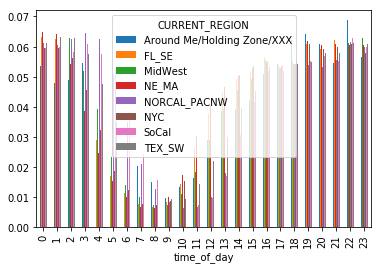

In [109]:
df.groupby('CURRENT_REGION')['time_of_day'].value_counts(normalize=True).unstack().T.plot(kind='bar')


timestamp fields are standarlized.

In [24]:
df.groupby('BOOKING_PURCHASED_IND')['NTH_SESSION'].describe()

,count,mean,std,min,25%,50%,75%,max
BOOKING_PURCHASED_IND,,,,,,,,
0,366301.0,131.884671,298.251763,1.0,13.0,38.0,118.0,5083.0
1,31378.0,67.341896,189.880072,1.0,4.0,14.0,51.0,5044.0


In [114]:
df.groupby('NEXT_SESSION_BOOK_IND')['NTH_SESSION'].describe()

,count,mean,std,min,25%,50%,75%,max
NEXT_SESSION_BOOK_IND,,,,,,,,
0.0,308574.0,4.277471,1.203265,0.0,3.433987,4.248495,5.105945,8.752581
1.0,19878.0,3.979989,1.170581,0.0,3.135494,3.951244,4.770685,8.211754


In [29]:
df.groupby('BOOKING_PURCHASED_IND')['CUMULATIVE_SESSION_BOOK_CNT'].describe()

,count,mean,std,min,25%,50%,75%,max
BOOKING_PURCHASED_IND,,,,,,,,
0,366301.0,0.301064,0.858063,0.0,0.0,0.0,0.0,19.0
1,31378.0,0.414526,1.160802,0.0,0.0,0.0,0.0,18.0


In [28]:
df.groupby('NEXT_SESSION_BOOK_IND')['CUMULATIVE_SESSION_BOOK_CNT'].describe()

,count,mean,std,min,25%,50%,75%,max
NEXT_SESSION_BOOK_IND,,,,,,,,
0.0,284500.0,0.324794,0.911343,0.0,0.0,0.0,0.0,19.0
1.0,21053.0,0.531611,1.317789,0.0,0.0,0.0,1.0,18.0


most of the bookings(98%) purchase only 1 unit , and our focus is whether purchase or not (binary)

In [129]:
df.NEXT_SESSION_BOOK_IND.value_counts(dropna=False,normalize=True)

0.0    0.931099
1.0    0.068901
Name: NEXT_SESSION_BOOK_IND, dtype: float64

In [30]:
df.groupby('BOOKING_PURCHASED_IND')['DISTANCE_MILE'].describe()

,count,mean,std,min,25%,50%,75%,max
BOOKING_PURCHASED_IND,,,,,,,,
0,366301.0,240.441133,586.307233,0.0,0.0,17.456310,151.860775,8238.065906
1,31378.0,177.049844,513.762065,0.0,0.0,4.967805,78.149390,8031.059186


In [57]:
df.head()

,CUSTOMER_ID,APP_SESSION_SK,SESSION_START_TIMESTAMP,SESSION_END_TIMESTAMP,SESSION_DURATION_MINS,NTH_SESSION,APP_LAUNCH_CNT,HOTEL_DETAILS_CNT,INVENTORY_REQUEST_CNT,ORDER_SUMMARY_VIEWED_CNT,BOOKING_PURCHASED_CNT,PRIOR_SESSION_BOOK_CNT,NEXT_SESSION_BOOK_IND,SESSION_START_DT,EVER_PURCHASED_IND,FIRST_PURCHASE_DT,CUMULATIVE_SESSION_BOOK_CNT,HOUR_SINCE_LAST_SESSION,DESTINATION_CNT,DESTINATION_LIST,USER_MARKET_CNT,EVENT_CNT,MKTG_CHANNEL_NAME,PLATFORM_NAME,MAX_NUM_NIGHTS,MIN_NUM_NIGHTS,AVG_NUM_NIGHTS,MAX_DAYS_SEARCHED_IN_ADVANCE,MIN_DAYS_SEARCHED_IN_ADVANCE,AVG_DAYS_SEARCHED_IN_ADVANCE,MAX_PRICE,MIN_PRICE,AVG_PRICE,MAX_DISCOUNT,MIN_DISCOUNT,AVG_DISCOUNT,HOTEL_VIEW_CNT,DEAL_TYPE_DIST_CNT,STANDARD_DEAL_CNT,TARGET_DEAL_CNT,GEO_DEAL_CNT,HTPERK_DEAL_CNT,DESTINATION_COUNTRY,DESTINATION_METRO,DESTINATION_REGION,AVG_DISTANCE_MILE,CURRENT_COUNTRY,CURRENT_METRO,CURRENT_REGION,BOOKING_POSITION,BOOKING_PRICE,BOOKING_DISCOUNT,day_of_week,time_of_day
0,4085040,120155875,2017-10-30 17:11:55.713,2017-10-30 17:13:47.360,2,436,1,1,3,0,0,0.0,0.0,2017-10-30,0,NaT,1,22.0,2,"1,115",1,3,CRM,Ios App,1,1,1.000,4,3,3.282,739.0,96.0,219.10256,1.0,0.46,0.80256,31,3,22,3,0,14,UNITED STATES,"San Francisco, CA",NORCAL_PACNW,229.405520,UNITED STATES,"Santa Monica, CA",SoCal,7.179,219.10256,1.27,Monday,17
1,4085040,225680293,2017-10-30 18:11:51.763,2017-10-30 18:24:11.066,13,437,3,3,4,0,0,0.0,0.0,2017-10-30,0,NaT,1,1.0,2,"1,115",1,4,CRM,Ios App,1,1,1.000,4,3,3.698,739.0,88.0,204.01886,1.0,0.38,0.77509,32,3,22,3,0,28,UNITED STATES,"Sonoma County, CA",NORCAL_PACNW,226.217652,UNITED STATES,"Santa Monica, CA",SoCal,7.320,204.01886,1.21,Monday,18
3,4085044,199699984,2017-10-01 12:55:39.341,2017-10-01 13:09:14.367,14,24,1,2,8,0,0,NaN,0.0,2017-10-01,0,NaT,0,NaN,2,"439,1",1,5,Organic,Ios App,3,1,2.184,5,0,2.960,799.0,67.0,201.60526,1.0,0.31,0.77263,46,2,42,0,0,34,UNITED STATES,"Chicago, IL",MidWest,2181.324090,UNITED STATES,"New York City, NJ",NYC,8.105,201.60526,0.85,Sunday,12
4,4085074,229444767,2017-10-31 01:59:46.545,2017-10-31 02:07:58.960,8,7,2,2,3,0,0,NaN,0.0,2017-10-31,0,NaT,0,NaN,2,"212,639",1,3,Organic,Ios App,1,1,1.000,0,0,0.000,739.0,65.0,141.95652,1.0,0.50,0.86347,31,4,33,8,2,3,UNITED STATES,"Sacramento, CA",NORCAL_PACNW,17.679192,UNITED STATES,"Sacramento, CA",NORCAL_PACNW,8.173,141.95652,1.58,Tuesday,1
6,4085086,81663969,2017-10-02 16:22:18.177,2017-10-02 16:23:18.842,1,220,1,1,3,0,0,NaN,0.0,2017-10-02,0,NaT,0,NaN,2,"3056,41",1,3,Organic,Ios App,3,1,1.680,2,0,0.680,479.0,110.0,254.57446,1.0,0.44,0.70978,42,4,21,4,6,16,UNITED STATES,"DC, DC",NE_MA,109.989670,UNITED STATES,"DC, DC",NE_MA,8.340,254.57446,0.74,Monday,16


In [60]:
df.groupby('BOOKING_PURCHASED_CNT')['AVG_DISTANCE_MILE'].mean()

BOOKING_PURCHASED_CNT
0    259.368631
1    209.044640
2    322.546140
3    755.666892
4     22.726591
6    806.827825
Name: AVG_DISTANCE_MILE, dtype: float64

In [37]:
df.loc[df['DISTANCE_MILE']==0]. groupby('BOOKING_PURCHASED_IND')['DISTANCE_MILE'].size()/(df.groupby('BOOKING_PURCHASED_IND')['DISTANCE_MILE'].size())

#train.loc[train['AVG_DAYS_SEARCHED_IN_ADVANCE']>0].groupby('BOOKING_PURCHASED_IND')['AVG_DAYS_SEARCHED_IN_ADVANCE'].describe()

BOOKING_PURCHASED_IND
0    0.261465
1    0.344126
Name: DISTANCE_MILE, dtype: float64

In [43]:

df.groupby('BOOKING_PURCHASED_IND')['DEAL_TYPE_DIST_CNT'].describe()

,count,mean,std,min,25%,50%,75%,max
BOOKING_PURCHASED_IND,,,,,,,,
0,366301.0,2.237884,0.916006,0.0,2.0,2.0,3.0,4.0
1,31378.0,2.316942,1.138174,0.0,2.0,3.0,3.0,4.0


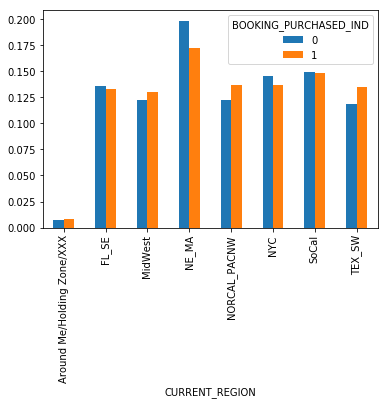

In [41]:
df.groupby('BOOKING_PURCHASED_IND')['CURRENT_REGION'].value_counts(normalize=True).unstack().T.plot(kind='bar')

In [131]:
df.groupby('NEXT_SESSION_BOOK_IND')['SESSION_DURATION_MINS'].describe()

,count,mean,std,min,25%,50%,75%,max
NEXT_SESSION_BOOK_IND,,,,,,,,
0,308574.0,6.100728,12.978233,0.0,0.0,1.0,5.0,1041.0
1,19878.0,8.566455,14.892987,0.0,1.0,2.5,10.0,377.0


In [113]:
df.NTH_SESSION.describe()

count    428959.000000
mean          4.087397
std           1.221075
min           0.000000
25%           3.218876
50%           4.043051
75%           4.919981
max           8.752740
Name: NTH_SESSION, dtype: float64

In [72]:
df['AVG_NUM_NIGHTS'].describe()

count    305553.000000
mean          1.291609
std           0.659851
min           1.000000
25%           1.000000
50%           1.000000
75%           1.142000
max          14.000000
Name: AVG_NUM_NIGHTS, dtype: float64

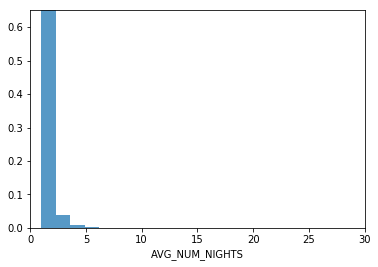

In [80]:
n, bins, patches = plt.hist(df.AVG_NUM_NIGHTS, 10, density = 1, alpha=0.75)
plt.xlabel('AVG_NUM_NIGHTS')
plt.axis([0, 30, 0, 0.65])
plt.show()

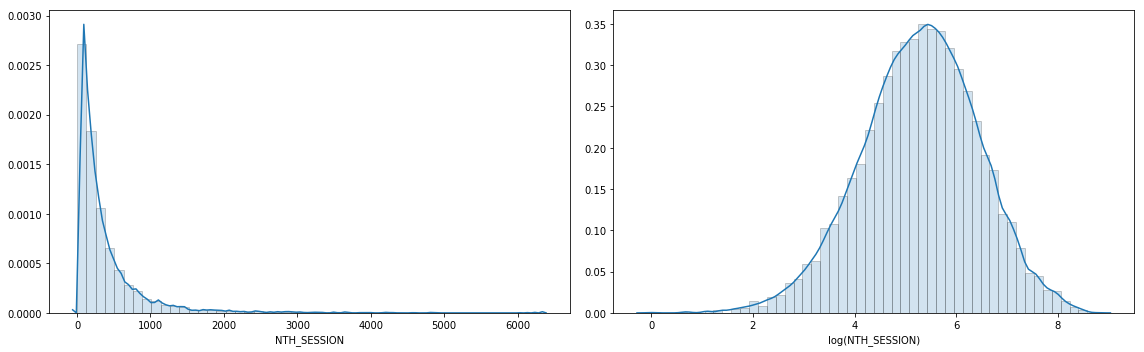

In [145]:
warnings.filterwarnings('ignore')
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.distplot(df['NTH_SESSION'], ax=ax[0], hist_kws=hist_kws)
sns.distplot(np.log(df['NTH_SESSION']), ax=ax[1], hist_kws=hist_kws)
ax[1].set_xlabel('log(NTH_SESSION)')
plt.tight_layout()
plt.show()

w

In [111]:
train['NTH_SESSION']=np.log(train['NTH_SESSION'])
train.NTH_SESSION.describe()

count    500000.000000
mean          4.084765
std           1.215266
min           0.000000
25%           3.218876
50%           4.043051
75%           4.912655
max           8.752740
Name: NTH_SESSION, dtype: float64

In [ ]:
# we can also category users with freqent users as well as high previous book as 'loyal customer'
def session_group(x):
    if x < 50:
        return 'New user'
    elif (x >= 2500) & (x <= 4500):
        return 'Regular user'
    else:
        return 'Heavy user'
    
train['session_group'] = train['NTH_SESSION'].apply(session_group)
train['session_group'] .value_counts(normalize=True)

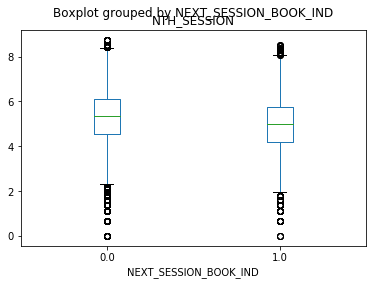

In [147]:
train.boxplot(by='NEXT_SESSION_BOOK_IND', 
                       column=['NTH_SESSION'], 
                       grid=False)

After normalizing NTH_SESSION, it looks like people in their early sessions are more likely to book but we need to dig more

In [62]:
user_session = df['CUSTOMER_ID'].value_counts()
user_session.describe()
# half of users have 5 sessions , we can use business rule to assign user groups here (!)

count    67508.000000
mean         4.865379
std          7.235395
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max        179.000000
Name: CUSTOMER_ID, dtype: float64

In [115]:
df['NEXT_SESSION_BOOK_IND']=df['NEXT_SESSION_BOOK_IND'].apply(pd.to_numeric)
df['NEXT_SESSION_BOOK_IND'].dtypes

dtype('float64')

In [116]:
data_types = df.dtypes  
catcols = list(data_types[data_types=='object'].index)
numcols = list(data_types[data_types=='int64'].index) + list(data_types[data_types=='float64'].index)

In [117]:
numcols.remove('CUSTOMER_ID')
numcols.remove('APP_SESSION_SK')

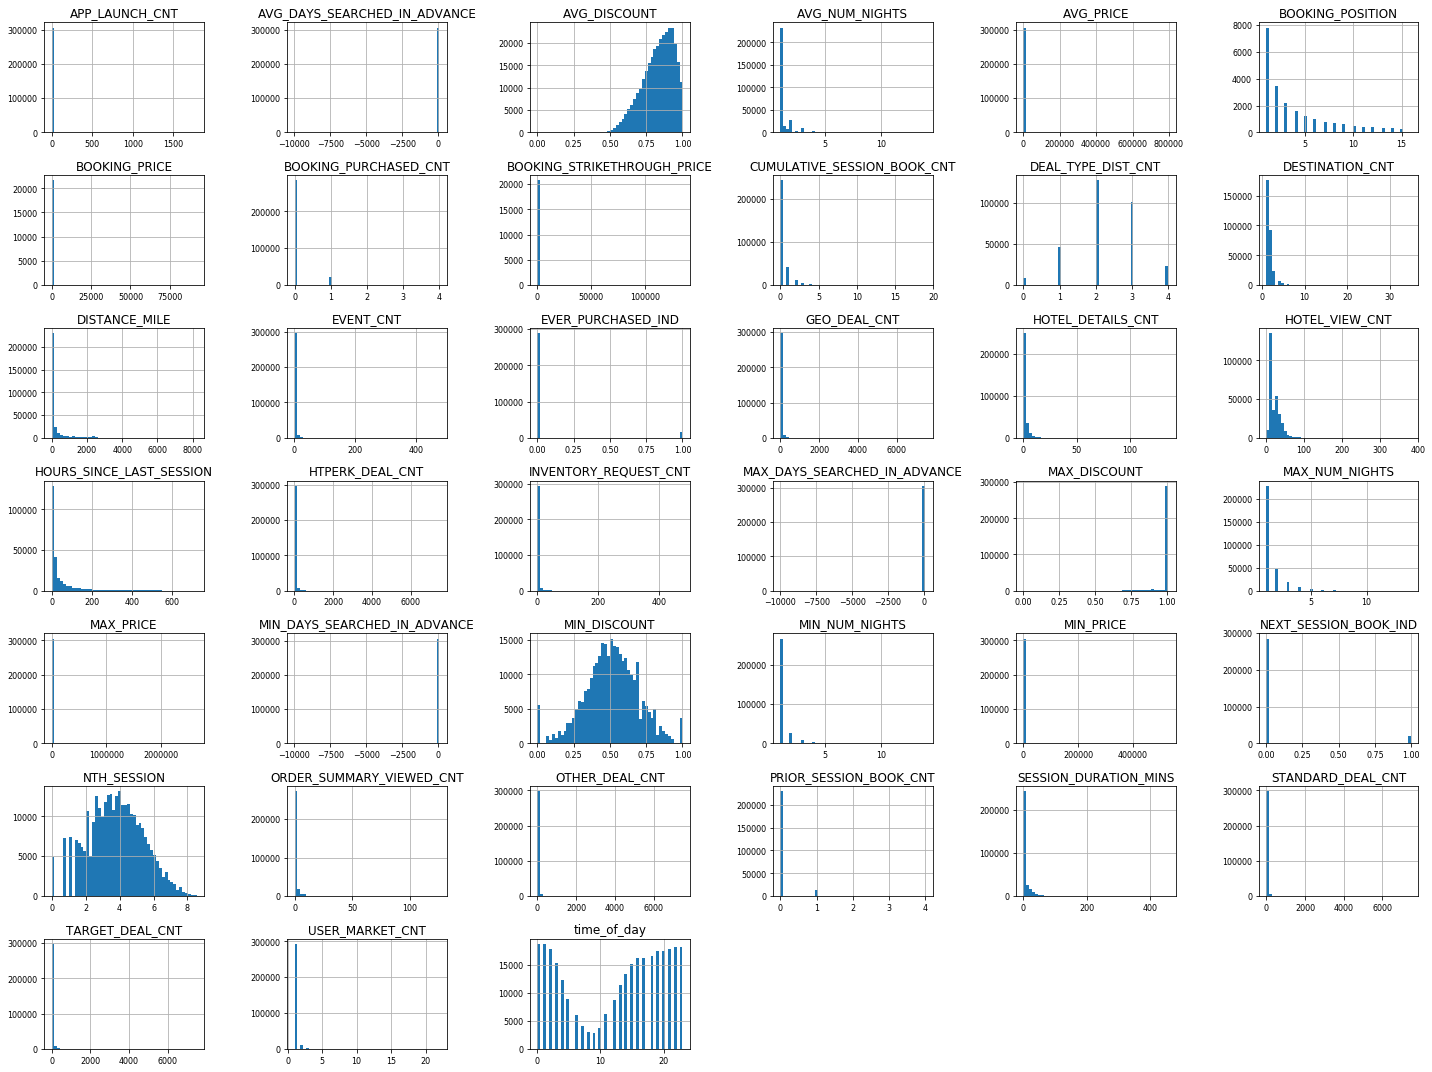

In [77]:
numcols.hist(figsize=(20, 15), bins=50, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

As we can see, many continous features are right skewed and need to do some scaling or transformation before modeling

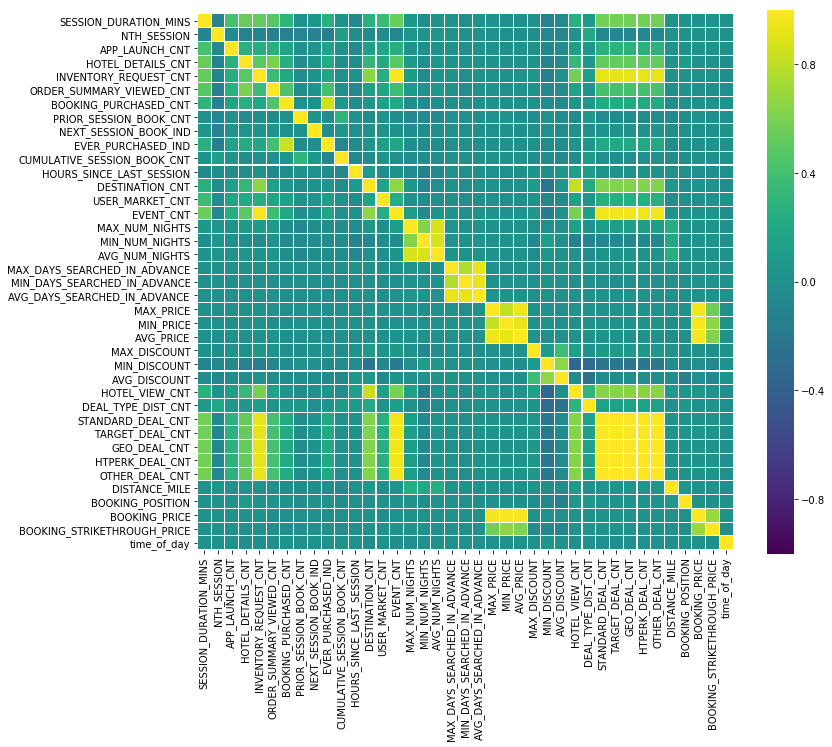

In [71]:
corr = numcols.corr() 
plt.figure(figsize=(12, 10))

sns.heatmap(corr, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 10}, square=True);

In [153]:
df.DESTINATION_REGION.value_counts(normalize=True)

NYC                           0.178368
NE_MA                         0.170982
SoCal                         0.139259
TEX_SW                        0.135309
FL_SE                         0.133489
NORCAL_PACNW                  0.124453
MidWest                       0.109765
Around Me/Holding Zone/XXX    0.008375
Name: DESTINATION_REGION, dtype: float64

In [117]:

dropcol =['CUSTOMER_ID','APP_SESSION_SK','FIRST_PURCHASE_DT','PRIOR_SESSION_BOOK_CNT','SESSION_START_TIMESTAMP','SESSION_END_TIMESTAMP','DESTINATION_COUNTRY','CURRENT_COUNTRY',
          'SESSION_START_DT','EVER_PURCHASED_IND','FIRST_PURCHASE_DT','DESTINATION_LIST','CURRENT_METRO','DESTINATION_METRO','BOOKING_PURCHASED_CNT']
          #'BOOKING_PURCHASED_CNT','BOOKING_POSITION',  'BOOKING_PRICE',  'BOOKING_DISCOUNT']

In [118]:
df =df.drop(dropcol, axis=1)

In [120]:
#hours_since_last_session = df.groupby('CUSTOMER_ID').apply(lambda x: (x['SESSION_START_TIMESTAMP'].shift(-1) - x['SESSION_START_TIMESTAMP'])).reset_index()
df = df.drop(df[df.NEXT_SESSION_BOOK_IND.isnull()].index)

In [121]:
(df.isnull().sum()/len(df))*100

SESSION_DURATION_MINS            0.00000
NTH_SESSION                      0.00000
APP_LAUNCH_CNT                   0.00000
HOTEL_DETAILS_CNT                0.00000
INVENTORY_REQUEST_CNT            0.00000
ORDER_SUMMARY_VIEWED_CNT         0.00000
NEXT_SESSION_BOOK_IND            0.00000
CUMULATIVE_SESSION_BOOK_CNT      0.00000
HOUR_SINCE_LAST_SESSION         20.10583
DESTINATION_CNT                  0.00000
USER_MARKET_CNT                  0.00000
EVENT_CNT                        0.00000
MKTG_CHANNEL_NAME                0.00000
PLATFORM_NAME                    0.00000
MAX_NUM_NIGHTS                   0.00000
MIN_NUM_NIGHTS                   0.00000
AVG_NUM_NIGHTS                   0.00000
MAX_DAYS_SEARCHED_IN_ADVANCE     0.00000
MIN_DAYS_SEARCHED_IN_ADVANCE     0.00000
AVG_DAYS_SEARCHED_IN_ADVANCE     0.00000
MAX_PRICE                        0.00000
MIN_PRICE                        0.00000
AVG_PRICE                        0.00000
MAX_DISCOUNT                     0.00000
MIN_DISCOUNT    

In [122]:
# impute missing value
df = df.fillna(value=0)

In [124]:
df.dtypes

SESSION_DURATION_MINS             int64
NTH_SESSION                     float64
APP_LAUNCH_CNT                    int64
HOTEL_DETAILS_CNT                 int64
INVENTORY_REQUEST_CNT             int64
ORDER_SUMMARY_VIEWED_CNT          int64
NEXT_SESSION_BOOK_IND             int64
CUMULATIVE_SESSION_BOOK_CNT       int64
HOUR_SINCE_LAST_SESSION         float64
DESTINATION_CNT                   int64
USER_MARKET_CNT                   int64
EVENT_CNT                         int64
MKTG_CHANNEL_NAME                object
PLATFORM_NAME                    object
MAX_NUM_NIGHTS                    int64
MIN_NUM_NIGHTS                    int64
AVG_NUM_NIGHTS                  float64
MAX_DAYS_SEARCHED_IN_ADVANCE      int64
MIN_DAYS_SEARCHED_IN_ADVANCE      int64
AVG_DAYS_SEARCHED_IN_ADVANCE    float64
MAX_PRICE                       float64
MIN_PRICE                       float64
AVG_PRICE                       float64
MAX_DISCOUNT                    float64
MIN_DISCOUNT                    float64


In [123]:
#b=int(df.loc[df['NEXT_SESSION_BOOK_IND']])
df.NEXT_SESSION_BOOK_IND = df.NEXT_SESSION_BOOK_IND.astype(int)
df.NEXT_SESSION_BOOK_IND.dtypes

dtype('int64')

In [150]:
df.MIN_DAYS_SEARCHED_IN_ADVANCE.describe()

count    305553.000000
mean          0.697411
std          57.342044
min       -9999.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          98.000000
Name: MIN_DAYS_SEARCHED_IN_ADVANCE, dtype: float64

In [125]:
# balance sample
book_indices = df[df.NEXT_SESSION_BOOK_IND == 1].index
random_indices = np.random.choice(book_indices, len(df.loc[df.NEXT_SESSION_BOOK_IND == 1]), replace=False)
book_sample = df.loc[random_indices]

not_book = df[df.NEXT_SESSION_BOOK_IND == 0].index
random_indices = np.random.choice(not_book, sum(df['NEXT_SESSION_BOOK_IND']), replace=False)
not_book_sample = df.loc[random_indices]

df_new = pd.concat([not_book_sample, book_sample], axis=0)

print("Percentage of not book impressions: ", len(df_new[df_new.NEXT_SESSION_BOOK_IND == 0])/len(df_new))
print("Percentage of book impression: ", len(df_new[df_new.NEXT_SESSION_BOOK_IND == 1])/len(df_new))
print("Total number of records in resampled data: ", len(df_new))

Percentage of not book impressions:  0.5
Percentage of book impression:  0.5
Total number of records in resampled data:  39756


In [126]:
df_new.head()

,SESSION_DURATION_MINS,NTH_SESSION,APP_LAUNCH_CNT,HOTEL_DETAILS_CNT,INVENTORY_REQUEST_CNT,ORDER_SUMMARY_VIEWED_CNT,NEXT_SESSION_BOOK_IND,CUMULATIVE_SESSION_BOOK_CNT,HOUR_SINCE_LAST_SESSION,DESTINATION_CNT,USER_MARKET_CNT,EVENT_CNT,MKTG_CHANNEL_NAME,PLATFORM_NAME,MAX_NUM_NIGHTS,MIN_NUM_NIGHTS,AVG_NUM_NIGHTS,MAX_DAYS_SEARCHED_IN_ADVANCE,MIN_DAYS_SEARCHED_IN_ADVANCE,AVG_DAYS_SEARCHED_IN_ADVANCE,MAX_PRICE,MIN_PRICE,AVG_PRICE,MAX_DISCOUNT,MIN_DISCOUNT,AVG_DISCOUNT,HOTEL_VIEW_CNT,DEAL_TYPE_DIST_CNT,STANDARD_DEAL_CNT,TARGET_DEAL_CNT,GEO_DEAL_CNT,HTPERK_DEAL_CNT,DESTINATION_REGION,AVG_DISTANCE_MILE,CURRENT_REGION,BOOKING_POSITION,BOOKING_PRICE,BOOKING_DISCOUNT,day_of_week,time_of_day
469684,7,5.560682,3,2,5,0,0,2,19.0,2,1,5,Organic,Ios App,1,1,1.0,1,0,0.200,560.0,96.0,280.62666,1.0,0.32,0.81746,28,3,53,0,7,15,FL_SE,0.049249,FL_SE,8.000,280.62666,1.19,Thursday,23
371369,0,4.927254,1,1,1,0,0,1,2.0,1,1,1,CRM,Ios App,1,1,1.0,1,1,1.000,829.0,110.0,406.12500,1.0,0.58,0.88250,16,2,13,0,0,3,NYC,671.276059,FL_SE,8.500,406.12500,1.49,Wednesday,0
60698,1,4.454347,1,2,1,0,0,0,2.0,1,1,1,CRM,Ios App,2,2,2.0,2,2,2.000,665.0,207.0,319.73333,1.0,0.70,0.85466,15,3,10,1,0,4,NYC,1252.390527,TEX_SW,8.000,319.73333,0.94,Monday,12
50721,1,7.011214,2,0,3,0,0,0,45.0,1,1,3,Organic,Ios App,1,1,1.0,8,4,5.155,429.0,136.0,288.04444,1.0,0.37,0.79222,28,3,20,6,0,19,NYC,154.090546,NE_MA,8.066,288.04444,0.86,Saturday,18
322849,0,3.401197,1,0,5,0,0,1,18.0,1,1,5,Organic,Ios App,1,1,1.0,0,0,0.000,306.0,0.0,133.05555,1.0,0.00,0.49666,12,2,17,0,1,0,NORCAL_PACNW,0.000000,NORCAL_PACNW,3.722,133.05555,0.65,Saturday,23


### Predictive model

In [76]:
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator


In [77]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,18 hours 28 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.1
H2O cluster version age:,1 month
H2O cluster name:,yurungu
H2O cluster total nodes:,1
H2O cluster free memory:,1.883 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [78]:
# Transform to H2O Frame, 
h2o_df = H2OFrame(df_new)
target = 'NEXT_SESSION_BOOK_IND'
feature = [x for x in h2o_df.columns if x not in target]

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [79]:
h2o_df['NEXT_SESSION_BOOK_IND'] = h2o_df['NEXT_SESSION_BOOK_IND'].asfactor()
h2o_df['MKTG_CHANNEL_NAME'] = h2o_df['MKTG_CHANNEL_NAME'].asfactor()
h2o_df['PLATFORM_NAME'] = h2o_df['PLATFORM_NAME'].asfactor()
h2o_df['DESTINATION_REGION'] = h2o_df['DESTINATION_REGION'].asfactor()
h2o_df['CURRENT_REGION'] = h2o_df['CURRENT_REGION'].asfactor()
h2o_df['day_of_week'] = h2o_df['day_of_week'].asfactor()

h2o_df.summary()

,SESSION_DURATION_MINS,NTH_SESSION,APP_LAUNCH_CNT,HOTEL_DETAILS_CNT,INVENTORY_REQUEST_CNT,ORDER_SUMMARY_VIEWED_CNT,NEXT_SESSION_BOOK_IND,CUMULATIVE_SESSION_BOOK_CNT,HOUR_SINCE_LAST_SESSION,DESTINATION_CNT,USER_MARKET_CNT,EVENT_CNT,MKTG_CHANNEL_NAME,PLATFORM_NAME,MAX_NUM_NIGHTS,MIN_NUM_NIGHTS,AVG_NUM_NIGHTS,MAX_DAYS_SEARCHED_IN_ADVANCE,MIN_DAYS_SEARCHED_IN_ADVANCE,AVG_DAYS_SEARCHED_IN_ADVANCE,MAX_PRICE,MIN_PRICE,AVG_PRICE,MAX_DISCOUNT,MIN_DISCOUNT,AVG_DISCOUNT,HOTEL_VIEW_CNT,DEAL_TYPE_DIST_CNT,STANDARD_DEAL_CNT,TARGET_DEAL_CNT,GEO_DEAL_CNT,HTPERK_DEAL_CNT,DESTINATION_REGION,AVG_DISTANCE_MILE,CURRENT_REGION,day_of_week,time_of_day
type,int,int,int,int,int,int,enum,int,int,int,int,int,enum,enum,int,int,real,int,int,real,int,int,real,real,real,real,int,int,int,int,int,int,enum,real,enum,enum,int
mins,0.0,1.0,0.0,0.0,1.0,0.0,,0.0,0.0,1.0,1.0,1.0,,,1.0,1.0,1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,,0.0,,,0.0
mean,7.3326038836905045,130.07918301640035,1.9655649461716482,1.6052168226179633,3.2956031793942993,0.8500100613743831,,0.5128785592111883,34.10529228292569,1.6957188851997171,1.0637136532850373,3.1847771405574163,,,1.384948183921926,1.16865378810745,1.2629958245296302,1.8820555387865892,0.8015645437166761,1.260883111983101,495.6129137740214,98.87576717979685,204.89093790748666,0.9921526310494,0.502389073347422,0.8261943749371181,24.736316530838113,2.4277593319247517,29.415761142972123,4.1970771707415215,1.3777543012375604,7.025379816882998,,241.3661480523861,,,12.772084716772305
maxs,377.0,3711.0,60.0,85.0,147.0,86.0,,21.0,712.0,35.0,7.0,136.0,,,14.0,14.0,14.0,99.0,93.0,93.0,465290.0,27935.0,84606.67968,1.0,1.0,1.0,215.0,4.0,1243.0,325.0,337.0,330.0,,7776.13677262,,,23.0
sigma,13.775873637443382,223.77262279355597,2.06755398590365,3.065276818308332,4.189931909171117,2.5183647444201274,,1.3082019848229873,72.90752542193019,1.1543458904372985,0.313997169602931,3.9061967710386547,,,0.8691349855013811,0.5656537716914275,0.6342436142177543,5.584903286714658,3.3360840049561524,3.7995981173139515,2616.22255359883,215.1726602916638,577.4590279659972,0.03867584972109412,0.18325538238554615,0.10795152070455803,14.39600274859436,0.8835266911319642,36.546151671054545,10.245624973600512,4.870024602383524,12.677757240819231,,577.0694380909968,,,7.758731125715019
zeros,11120,0,723,19134,0,31705,,29702,8270,0,0,0,,,0,0,0,22495,29596,22227,19,1224,19,6,895,6,0,740,1131,20967,27375,13033,,9387,,,2419
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,150.0,1.0,1.0,1.0,0.0,0,0.0,140.0,1.0,1.0,1.0,Organic,Ios App,1.0,1.0,1.0,0.0,0.0,0.0,140.0,77.0,100.86666,1.0,0.75,0.94,15.0,2.0,13.0,0.0,2.0,0.0,MidWest,0.0,MidWest,Sunday,17.0
1,5.0,7.0,1.0,2.0,1.0,0.0,0,0.0,1.0,1.0,1.0,1.0,Organic,Android App,1.0,1.0,1.0,0.0,0.0,0.0,229.0,100.0,164.26666,1.0,0.83,0.97533,15.0,1.0,15.0,0.0,0.0,0.0,NE_MA,0.0,NE_MA,Saturday,23.0
2,8.0,9.0,1.0,1.0,22.0,0.0,0,0.0,0.0,14.0,1.0,21.0,Organic,Android App,1.0,1.0,1.0,0.0,0.0,0.0,991.0,98.0,285.2653,1.0,0.37,0.82453,105.0,3.0,239.0,3.0,0.0,3.0,TEX_SW,141.854695224,NYC,Saturday,23.0


In [80]:
h2o_df.shape

(39756, 37)

In [81]:
#Split the data into Train/Test/Validation with Train having 75% and test and validation 15% each

train, valid, test = h2o_df.split_frame([0.60, 0.2], seed=1234)

In [82]:
# 1. Build a baseline model by using random forest  
start = time.time() 
model = H2ORandomForestEstimator(balance_classes=True, ntrees=150, max_depth=10, nfolds=3,
                                 stopping_metric = 'AUC', seed=1289, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)
end = time.time()
print ('training time:', (end - start)/60)

drf Model Build progress: |███████████████████████████████████████████████| 100%
training time: 1.9815400997797648


In [83]:
model.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39183607813468924: 


,0,1,Error,Rate
0,3219.0,8753.0,0.7311,(8753.0/11972.0)
1,1099.0,10875.0,0.0918,(1099.0/11974.0)
Total,4318.0,19628.0,0.4114,(9852.0/23946.0)


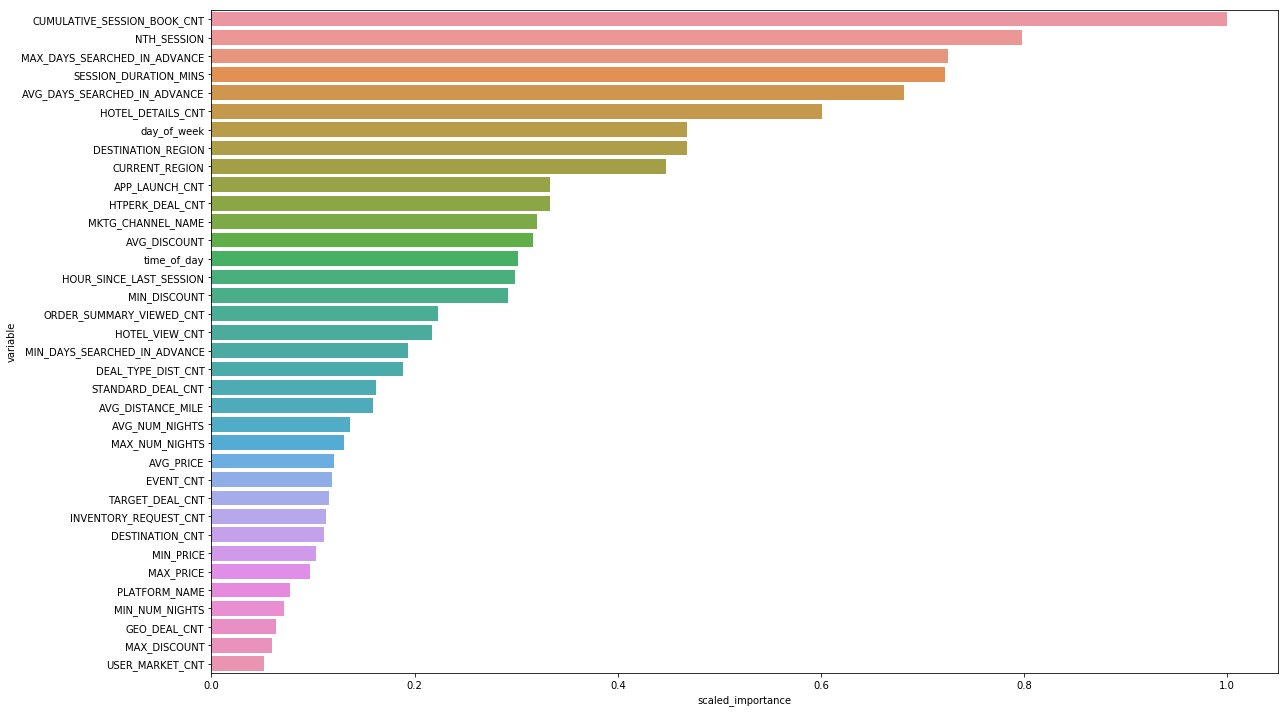

In [85]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.tight_layout()
plt.show()

In [86]:
# Make predictions
train_true = train.as_data_frame()['NEXT_SESSION_BOOK_IND'].values
test_true = test.as_data_frame()['NEXT_SESSION_BOOK_IND'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [168]:
test_pred_df = pd.DataFrame(test_pred, columns=['test_pred'])

In [169]:
test_pred_df.head()

,test_pred
0,0.281094
1,0.477263
2,0.642566
3,0.401033
4,0.600971


In [186]:
test=test.as_data_frame(use_pandas=True, header=True)

In [188]:
result = pd.concat([test, test_pred_df], axis=1, sort=False)
result.head()

,SESSION_DURATION_MINS,NTH_SESSION,APP_LAUNCH_CNT,HOTEL_DETAILS_CNT,INVENTORY_REQUEST_CNT,ORDER_SUMMARY_VIEWED_CNT,NEXT_SESSION_BOOK_IND,CUMULATIVE_SESSION_BOOK_CNT,HOURS_SINCE_LAST_SESSION,DESTINATION_CNT,USER_MARKET_CNT,EVENT_CNT,MKTG_CHANNEL_NAME,PLATFORM_NAME,MAX_NUM_NIGHTS,MIN_NUM_NIGHTS,AVG_NUM_NIGHTS,MAX_DAYS_SEARCHED_IN_ADVANCE,MIN_DAYS_SEARCHED_IN_ADVANCE,AVG_DAYS_SEARCHED_IN_ADVANCE,MAX_PRICE,MIN_PRICE,AVG_PRICE,MAX_DISCOUNT,MIN_DISCOUNT,AVG_DISCOUNT,HOTEL_VIEW_CNT,DEAL_TYPE_DIST_CNT,STANDARD_DEAL_CNT,TARGET_DEAL_CNT,GEO_DEAL_CNT,HTPERK_DEAL_CNT,OTHER_DEAL_CNT,DESTINATION_REGION,DISTANCE_MILE,CURRENT_REGION,day_of_week,time_of_day,test_pred
0,0,18,1,0,1,0,0,0,23,1,1,1,CRM,Ios App,3,3,3.000,5,5,5.000,253,50,106.20000,1.0,0.78,0.96200,15,1,15,15,15,15,15,NE_MA,153.330921,NE_MA,Sunday,23,0.281094
1,1,112,1,0,1,0,0,0,3,1,1,1,Organic,Ios App,2,2,2.000,1,1,1.000,155,76,98.13333,1.0,0.62,0.76200,15,3,15,15,15,15,15,MidWest,281.624687,MidWest,Friday,2,0.477263
2,3,1,2,1,3,2,0,0,0,2,1,3,Organic,Ios App,1,1,1.000,1,0,0.348,329,56,159.30232,1.0,0.48,0.97906,36,2,43,43,43,43,43,NE_MA,38.474528,NE_MA,Thursday,20,0.642566
3,1,5,2,0,3,0,0,0,0,2,1,3,Organic,Ios App,3,1,1.909,6,0,2.727,351,58,151.90909,1.0,0.43,0.91151,29,2,33,33,33,33,33,FL_SE,93.101946,FL_SE,Friday,23,0.401033
4,3,13,1,2,2,2,0,0,307,2,1,2,Organic,Ios App,1,1,1.000,0,0,0.000,249,90,145.66666,1.0,0.33,0.76133,30,3,30,30,30,30,30,NYC,5.605245,NYC,Sunday,18,0.600971


In [189]:
result['decile'] = pd.qcut(result['test_pred'], 10, labels=False)
result.head()

,SESSION_DURATION_MINS,NTH_SESSION,APP_LAUNCH_CNT,HOTEL_DETAILS_CNT,INVENTORY_REQUEST_CNT,ORDER_SUMMARY_VIEWED_CNT,NEXT_SESSION_BOOK_IND,CUMULATIVE_SESSION_BOOK_CNT,HOURS_SINCE_LAST_SESSION,DESTINATION_CNT,USER_MARKET_CNT,EVENT_CNT,MKTG_CHANNEL_NAME,PLATFORM_NAME,MAX_NUM_NIGHTS,MIN_NUM_NIGHTS,AVG_NUM_NIGHTS,MAX_DAYS_SEARCHED_IN_ADVANCE,MIN_DAYS_SEARCHED_IN_ADVANCE,AVG_DAYS_SEARCHED_IN_ADVANCE,MAX_PRICE,MIN_PRICE,AVG_PRICE,MAX_DISCOUNT,MIN_DISCOUNT,AVG_DISCOUNT,HOTEL_VIEW_CNT,DEAL_TYPE_DIST_CNT,STANDARD_DEAL_CNT,TARGET_DEAL_CNT,GEO_DEAL_CNT,HTPERK_DEAL_CNT,OTHER_DEAL_CNT,DESTINATION_REGION,DISTANCE_MILE,CURRENT_REGION,day_of_week,time_of_day,test_pred,decile
0,0,18,1,0,1,0,0,0,23,1,1,1,CRM,Ios App,3,3,3.000,5,5,5.000,253,50,106.20000,1.0,0.78,0.96200,15,1,15,15,15,15,15,NE_MA,153.330921,NE_MA,Sunday,23,0.281094,0
1,1,112,1,0,1,0,0,0,3,1,1,1,Organic,Ios App,2,2,2.000,1,1,1.000,155,76,98.13333,1.0,0.62,0.76200,15,3,15,15,15,15,15,MidWest,281.624687,MidWest,Friday,2,0.477263,3
2,3,1,2,1,3,2,0,0,0,2,1,3,Organic,Ios App,1,1,1.000,1,0,0.348,329,56,159.30232,1.0,0.48,0.97906,36,2,43,43,43,43,43,NE_MA,38.474528,NE_MA,Thursday,20,0.642566,8
3,1,5,2,0,3,0,0,0,0,2,1,3,Organic,Ios App,3,1,1.909,6,0,2.727,351,58,151.90909,1.0,0.43,0.91151,29,2,33,33,33,33,33,FL_SE,93.101946,FL_SE,Friday,23,0.401033,2
4,3,13,1,2,2,2,0,0,307,2,1,2,Organic,Ios App,1,1,1.000,0,0,0.000,249,90,145.66666,1.0,0.33,0.76133,30,3,30,30,30,30,30,NYC,5.605245,NYC,Sunday,18,0.600971,7


In [194]:
df.NEXT_SESSION_BOOK_IND.mean()

0.06890130353817504

In [196]:
result.NEXT_SESSION_BOOK_IND.mean()

0.5057609217474796

In [192]:
decile=result.groupby('decile')['NEXT_SESSION_BOOK_IND'].mean().reset_index()
decile

,decile,NEXT_SESSION_BOOK_IND
0,0,0.195444
1,1,0.336134
2,2,0.358944
3,3,0.422569
4,4,0.478992
5,5,0.545018
6,6,0.632653
7,7,0.661465
8,8,0.690276
9,9,0.736211


In [159]:

# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

             precision    recall  f1-score   support

          0       0.66      0.59      0.62      4118
          1       0.64      0.70      0.67      4214

avg / total       0.65      0.65      0.65      8332



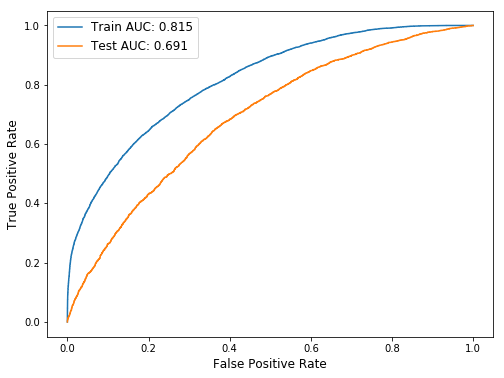

In [87]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


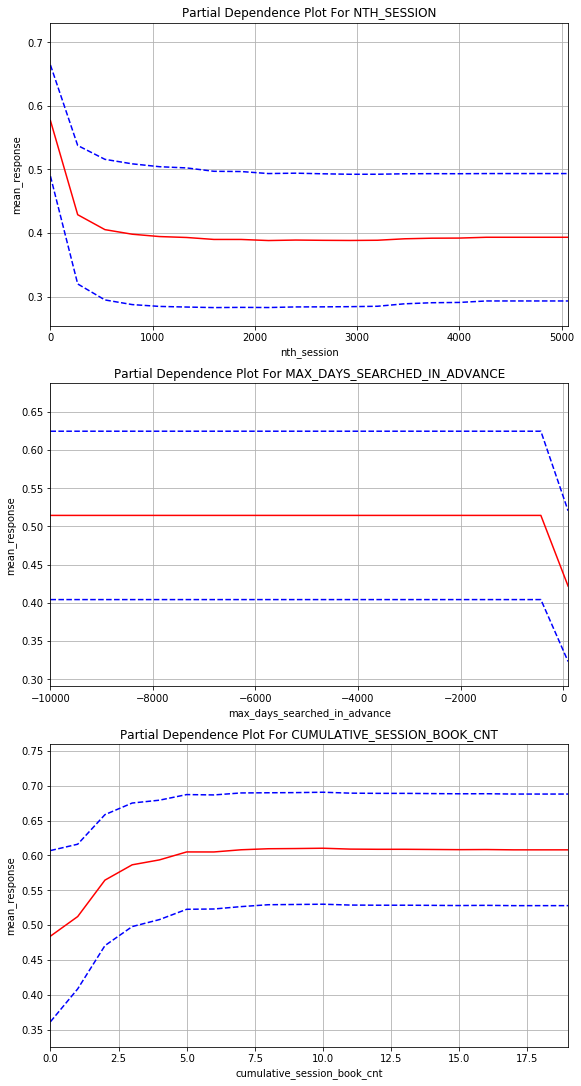

In [69]:
# Deep dive of top important features
_ =model.partial_plot(train, cols=['NTH_SESSION','MAX_DAYS_SEARCHED_IN_ADVANCE','CUMULATIVE_SESSION_BOOK_CNT'], figsize=(8, 15))

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


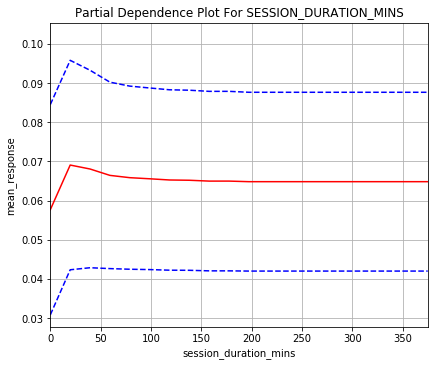

In [173]:
_ =model.partial_plot(train, cols=['SESSION_DURATION_MINS'], figsize=(6, 5))

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


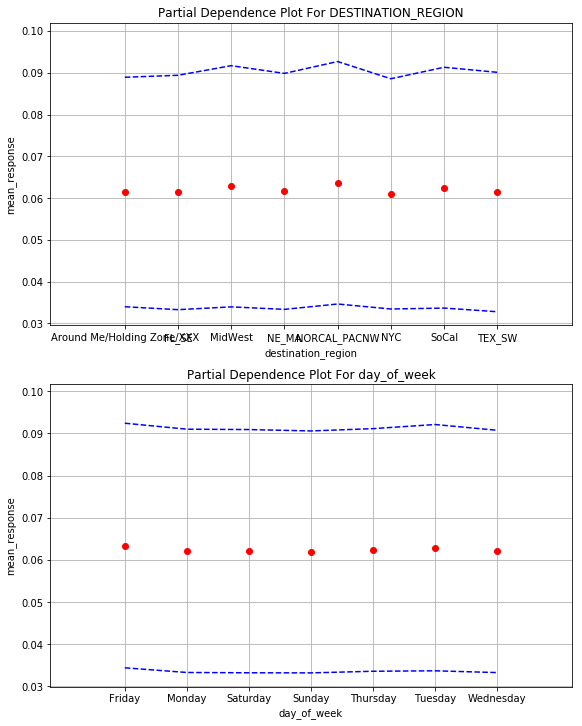

In [175]:
_ =model.partial_plot(train, cols=['DESTINATION_REGION','day_of_week'], figsize=(8,10))

In [47]:
#  2. Tune Parameter
# Prepare the hyperparameters
nfolds = 3
rf_params = {   'ntrees':[50,100,150],
                'max_depth': [5,10,20],
                'sample_rate': [0.8, 1.0]              # Row sample rate
                #,'mtries' : [-1,4,2]
                }


# Search criteria for parameter space
search_criteria = {'strategy': "RandomDiscrete",
                   "seed": 18,
                   'stopping_metric': "AUC", 
                   'stopping_rounds': 5
                   }


# Prepare the grid object
rf_grid = H2OGridSearch(model=H2ORandomForestEstimator,   # Model to be trained
                          grid_id='rf_grid',                  # Grid Search ID
                          hyper_params=rf_params,              # Dictionary of parameters
                          search_criteria=search_criteria,   # RandomDiscrete
                          )


In [48]:
# 3. Train the Model

rf_grid.train(x=feature,y=target, 
                training_frame=train,
                validation_frame=valid,
                score_each_iteration=True,
                nfolds = nfolds,
                fold_assignment= "Modulo",
                seed=1789
                )

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [50]:
# 4. Find the Model performance 
rf_gridperf = rf_grid.get_grid(sort_by='AUC',decreasing = True)
rf_gridperf

     max_depth ntrees sample_rate         model_ids                 auc
0           10    150         1.0  rf_grid_model_13  0.6922112317426949
1           10    100         1.0   rf_grid_model_9  0.6919998571414414
2           10    150         0.8  rf_grid_model_11   0.691971798495276
3           10    100         0.8  rf_grid_model_12  0.6917746301707278
4           10     50         1.0  rf_grid_model_15  0.6902808736663825
5           10     50         0.8   rf_grid_model_6  0.6898169772480669
6           20    150         0.8   rf_grid_model_1  0.6891496821381078
7           20    150         1.0  rf_grid_model_18  0.6879124603990789
8           20    100         1.0  rf_grid_model_10  0.6865405959482891
9           20    100         0.8  rf_grid_model_16  0.6864640280158254
10          20     50         1.0  rf_grid_model_17  0.6821384916869907
11           5    100         0.8   rf_grid_model_7  0.6819606163059936
12           5    100         1.0  rf_grid_model_14  0.681681211

In [ ]:
# 5. Identify the best model generated with least error
best_rf_model = rf_gridperf.models[0]
best_rf_model

In [62]:
gbm = H2OGradientBoostingEstimator(nfolds = 3, fold_assignment = "Modulo",keep_cross_validation_predictions = True,

                                   min_rows = 4, ntrees = 50, max_depth = 3, learn_rate = 0.01, balance_classes=True,

                                   stopping_metric = 'AUC', stopping_rounds = 3, stopping_tolerance = 1e-4, score_tree_interval = 10, seed = 333)

gbm.train(x = feature, y = target, training_frame = train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [64]:
gbm.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44601232393875473: 


,0,1,Error,Rate
0,3580.0,12269.0,0.7741,(12269.0/15849.0)
1,1104.0,14742.0,0.0697,(1104.0/15846.0)
Total,4684.0,27011.0,0.4219,(13373.0/31695.0)


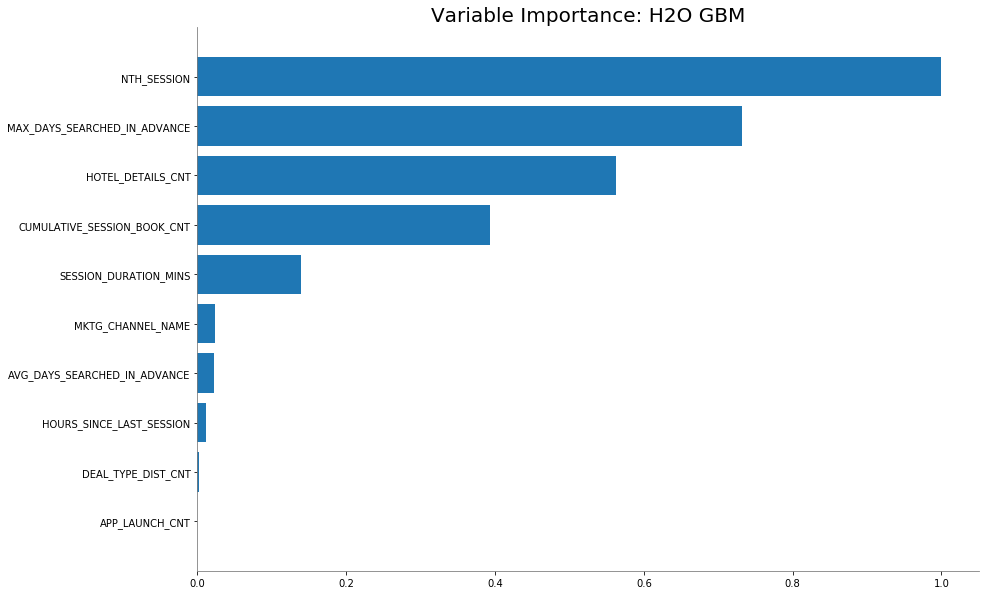

In [66]:
gbm.varimp_plot()

In [67]:
gbm.cross_validation_metrics_summary()

Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
accuracy,0.5771023,0.0076598,0.5617946,0.5842345,0.5852779
auc,0.6759098,0.0017731,0.678362,0.6769021,0.6724652
err,0.4228977,0.0076598,0.4382054,0.4157655,0.4147221
err_count,4458.3335,80.89568,4620.0,4383.0,4372.0
f0point5,0.5939287,0.0041914,0.5855466,0.5980173,0.5982221
f1,0.6865954,0.0014417,0.6843831,0.6893032,0.6861000
f2,0.8136939,0.0055204,0.8233612,0.8134788,0.8042417
lift_top_group,1.4522734,0.0360412,1.5213244,1.3998349,1.4356607
logloss,0.669083,0.0002962,0.6687496,0.6688256,0.6696738
max_per_class_error,0.7726671,0.0276542,0.8269922,0.7544956,0.7365133


In [63]:
# gbm.confusion_matrix()

# gbm.varimp_plot()

# gbm.cross_validation_metrics_summary()

gbm.model_performance().auc()

0.6798821878767247

In [1]:
h2o.cluster().shutdown()

NameError: name 'h2o' is not defined

### Unsupervised learning

In [83]:
repeat.isnull().sum()/len(repeat)

CUSTOMER_ID                        0.000000
FIRST_PURCHASE_DT                  0.000000
DAY_SINCE_FIRST_BUY                0.000000
NTH_SESSION_CNT                    0.000000
AVG_APP_LAUNCH_CNT                 0.000000
AVG_HOTEL_DETAILS_CNT              0.000000
AVG_INVENTORY_REQUEST_CNT          0.000000
AVG_ORDER_SUMMARY_VIEWED_CNT       0.000000
AVG_BOOKING_PURCHASED_CNT          0.000000
AVG_DESTINATION_CNT                0.000000
AVG_EVENT_CNT                      0.000000
AVG_BOOKING_POSITION               0.019015
AVG_BOOKING_PRICE                  0.019015
AVG_BOOKING_STRIKETHROUGH_PRICE    0.059841
AVG_BOOKING_DISCOUNT               0.019015
BOOK_DEAL_CNT                      0.000000
MKTG_CHANNEL_CNT                   0.000000
REPEAT_BUY                         0.000000
AVG_BOOKING_DEAL_CNT               0.000000
dtype: float64

In [84]:
repeat.shape

(142729, 19)

In [85]:
repeat.dropna(inplace=True)

In [86]:
repeat.shape

(134188, 19)

In [78]:
repeat[['DAY_SINCE_FIRST_BUY',
'NTH_SESSION_CNT',
'AVG_APP_LAUNCH_CNT',
'AVG_HOTEL_DETAILS_CNT',
'AVG_INVENTORY_REQUEST_CNT',
'AVG_ORDER_SUMMARY_VIEWED_CNT',
'AVG_BOOKING_PURCHASED_CNT',
'AVG_DESTINATION_CNT',
'AVG_EVENT_CNT',
'AVG_BOOKING_POSITION',
'AVG_BOOKING_PRICE',
'AVG_BOOKING_STRIKETHROUGH_PRICE',
'AVG_BOOKING_DISCOUNT',
'AVG_BOOKING_DEAL_CNT',
'MKTG_CHANNEL_CNT']]=repeat[['DAY_SINCE_FIRST_BUY',
'NTH_SESSION_CNT',
'AVG_APP_LAUNCH_CNT',
'AVG_HOTEL_DETAILS_CNT',
'AVG_INVENTORY_REQUEST_CNT',
'AVG_ORDER_SUMMARY_VIEWED_CNT',
'AVG_BOOKING_PURCHASED_CNT',
'AVG_DESTINATION_CNT',
'AVG_EVENT_CNT',
'AVG_BOOKING_POSITION',
'AVG_BOOKING_PRICE',
'AVG_BOOKING_STRIKETHROUGH_PRICE',
'AVG_BOOKING_DISCOUNT',
'BOOK_DEAL_CNT',
'MKTG_CHANNEL_CNT']].apply(pd.to_numeric)

In [270]:
x = repeat[[
'AVG_DESTINATION_CNT',
'AVG_EVENT_CNT',
'AVG_BOOKING_PRICE'
]]
scaler = StandardScaler()
norm_x = scaler.fit_transform(x)

KeyError: "['AVG_DESTINATION_CNT' 'AVG_EVENT_CNT' 'AVG_BOOKING_PRICE'] not in index"

In [251]:
norm_x = pd.DataFrame(data=norm_x)

In [252]:
norm_x.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.775053,0.000269,-0.650002,-0.667687,-0.595386,-0.787298,-0.938272,-0.619552,-0.754527,-0.827561,0.001703,0.024130,-1.398290,-0.079700,0.997908
1,0.438605,0.278123,0.376828,0.098675,-0.400923,0.456626,-1.102201,-0.786508,-0.492817,-0.827561,-0.019635,-0.011982,-0.666703,-0.079700,0.997908
2,-1.467932,-0.277584,0.085198,-0.573789,-0.292751,0.111092,-0.562365,-0.619552,-0.318518,-0.535218,-0.029994,-0.039464,1.528055,-0.079700,-0.623874
3,0.550755,0.139196,-0.187235,-0.632387,-0.155058,-0.637682,-1.034369,0.158019,-0.143957,-0.827561,-0.024608,-0.023798,0.740193,-0.079700,-0.623874
4,1.111501,0.833830,-0.249318,-0.455887,-0.524166,-0.140458,1.065623,-0.514475,-0.611895,-0.125937,-0.022453,-0.024860,0.470069,1.937799,-0.623874


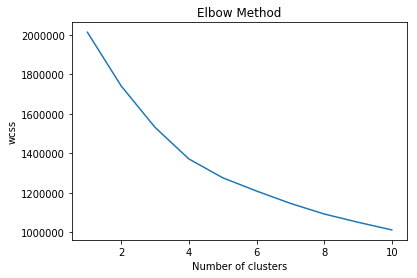

In [88]:
#Using the elbow method to find the optimum number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(norm_x)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

Based on the elbow plot, we could choose 4 or 5 clusters. Let us try both the number of clusters and visualize the clusters to decide on the final number of clusters.

In [241]:
##Fitting kmeans to the dataset with k=4
km4=KMeans(n_clusters=4,init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means = km4.fit_predict(norm_x)


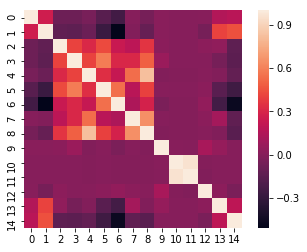

In [253]:
cor = norm_x.corr() #Calculate the correlation of the above variables
sns.heatmap(cor, square = True) #Plot the correlation as heat map

In [255]:
#K means Clustering 
def doKmeans(X, nclust=3):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

clust_labels, cent = doKmeans(norm_x, 3)
kmeans = pd.DataFrame(clust_labels)
norm_x.insert((norm_x.shape[1]),'kmeans',kmeans)

In [262]:
norm_x.columns=['DAY_SINCE_FIRST_BUY',
'NTH_SESSION_CNT',
'AVG_APP_LAUNCH_CNT',
'AVG_HOTEL_DETAILS_CNT',
'AVG_INVENTORY_REQUEST_CNT',
'AVG_ORDER_SUMMARY_VIEWED_CNT',
'AVG_BOOKING_PURCHASED_CNT',
'AVG_DESTINATION_CNT',
'AVG_EVENT_CNT',
'AVG_BOOKING_POSITION',
'AVG_BOOKING_PRICE',
'AVG_BOOKING_STRIKETHROUGH_PRICE',
'AVG_BOOKING_DISCOUNT',
'BOOK_DEAL_CNT',
'MKTG_CHANNEL_CNT','kmeans']

In [263]:
norm_x.head()

,DAY_SINCE_FIRST_BUY,NTH_SESSION_CNT,AVG_APP_LAUNCH_CNT,AVG_HOTEL_DETAILS_CNT,AVG_INVENTORY_REQUEST_CNT,AVG_ORDER_SUMMARY_VIEWED_CNT,AVG_BOOKING_PURCHASED_CNT,AVG_DESTINATION_CNT,AVG_EVENT_CNT,AVG_BOOKING_POSITION,AVG_BOOKING_PRICE,AVG_BOOKING_STRIKETHROUGH_PRICE,AVG_BOOKING_DISCOUNT,BOOK_DEAL_CNT,MKTG_CHANNEL_CNT,kmeans
0,0.775053,0.000269,-0.650002,-0.667687,-0.595386,-0.787298,-0.938272,-0.619552,-0.754527,-0.827561,0.001703,0.024130,-1.398290,-0.079700,0.997908,0
1,0.438605,0.278123,0.376828,0.098675,-0.400923,0.456626,-1.102201,-0.786508,-0.492817,-0.827561,-0.019635,-0.011982,-0.666703,-0.079700,0.997908,0
2,-1.467932,-0.277584,0.085198,-0.573789,-0.292751,0.111092,-0.562365,-0.619552,-0.318518,-0.535218,-0.029994,-0.039464,1.528055,-0.079700,-0.623874,1
3,0.550755,0.139196,-0.187235,-0.632387,-0.155058,-0.637682,-1.034369,0.158019,-0.143957,-0.827561,-0.024608,-0.023798,0.740193,-0.079700,-0.623874,0
4,1.111501,0.833830,-0.249318,-0.455887,-0.524166,-0.140458,1.065623,-0.514475,-0.611895,-0.125937,-0.022453,-0.024860,0.470069,1.937799,-0.623874,0


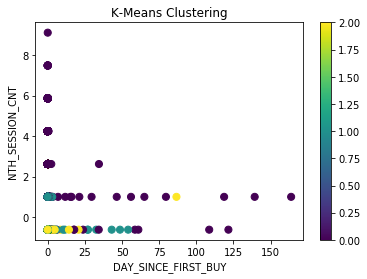

In [267]:
#Plot the clusters obtained using k means
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(norm_x['AVG_BOOKING_PRICE'],norm_x['MKTG_CHANNEL_CNT'],
                     c=kmeans[0],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('DAY_SINCE_FIRST_BUY')
ax.set_ylabel('NTH_SESSION_CNT')
plt.colorbar(scatter)

### Channel Attribution

In [139]:
cs = ctx.cursor()
user_logs_aggr= cs.execute("SELECT * from APP_CHANNEL_stp2").fetchall()
user_logs_aggr.head()

,channel,conversions_sum
0,"CRM,Organic",8587
1,"SEM (NA),",861
2,SEM (NA),1111
3,"Meta,Organic,Meta,Organic",6
4,"Display Ads,CRM,Organic",84


In [140]:
def v_function(A,C_values):
    '''
    This function computes the worth of each coalition.
    inputs:
            - A : a coalition of channels.
            - C_values : A dictionnary containing the number of conversions that each subset of channels has yielded.
    '''
    subsets_of_A = subsets(A.split(","))
    worth_of_A=0
    for subset in subsets_of_A:
        if subset in C_values:
            worth_of_A += C_values[subset]
    return worth_of_A

In [141]:
def subsets(s):
    '''
    This function returns all the possible subsets of a set of channels.
    input :
            - s: a set of channels.
    '''
    if len(s)==1:
        return s
    else:
        sub_channels=[]
        for i in range(1,len(s)+1):
            sub_channels.extend(map(list,itertools.combinations(s, i)))
    return map(",".join,map(sorted,sub_channels))

In [142]:
import itertools

In [143]:
# First, let's convert the dataframe "subsets_conversions" into a dictionnary
C_values = user_logs_aggr.set_index("channel").to_dict()["conversions_sum"]

#For each possible combination of channels A, we compute the total number of conversions yielded by every subset of A. 
# Example : if A = {c1,c2}, then v(A) = C({c1}) + C({c2}) + C({c1,c2})
v_values = {}
for A in subsets(channels):
    v_values[A] = v_function(A,C_values)

In [144]:
v_values

{'channel': 0, 'conversions_sum': 0, 'channel,conversions_sum': 0}

In [145]:
import math 
from collections import defaultdict

n=len(channels)
shapley_values = defaultdict(int)

for channel in channels:
    for A in v_values.keys():
        if channel not in A.split(","):
            cardinal_A=len(A.split(","))
            A_with_channel = A.split(",")
            A_with_channel.append(channel)            
            A_with_channel=",".join(sorted(A_with_channel))
            shapley_values[channel] += (v_values[A_with_channel]-v_values[A])*(math.factorial(cardinal_A)*math.factorial(n-cardinal_A-1)/math.factorial(n))
    # Add the term corresponding to the empty set
    shapley_values[channel]+= v_values[channel]/n 

In [146]:
for key, value in shapley_values.items() :
    print (key, value)

channel 0.0
conversions_sum 0.0


### Repeate buyer

In [219]:
repeat.BOOKING_PURCHASED_CNT.value_counts(dropna=False)

0    464642
1    182335
2      3804
3       249
4        23
6         3
5         3
7         2
Name: BOOKING_PURCHASED_CNT, dtype: int64

In [225]:
repeat.NEXT_SESSION_BOOK_IND.value_counts(dropna=False)

 0.0    478106
NaN     129251
 1.0     43704
Name: NEXT_SESSION_BOOK_IND, dtype: int64

In [226]:
repeat = repeat.loc[(repeat['CURRENT_COUNTRY'] == 'UNITED STATES') & (repeat['DESTINATION_COUNTRY'] == 'UNITED STATES')]

repeat = repeat.drop(repeat[repeat.NEXT_SESSION_BOOK_IND.isnull()].index)
print(repeat.shape)
repeat[['AVG_NUM_NIGHTS','AVG_DAYS_SEARCHED_IN_ADVANCE','MAX_PRICE','MIN_PRICE','AVG_PRICE','MAX_DISCOUNT','MIN_DISCOUNT' ,'AVG_DISCOUNT','BOOKING_PRICE','BOOKING_STRIKETHROUGH_PRICE']]=repeat[['AVG_NUM_NIGHTS','AVG_DAYS_SEARCHED_IN_ADVANCE','MAX_PRICE','MIN_PRICE','AVG_PRICE','MAX_DISCOUNT','MIN_DISCOUNT' ,'AVG_DISCOUNT','BOOKING_PRICE','BOOKING_STRIKETHROUGH_PRICE']].apply(pd.to_numeric)
repeat['NEXT_SESSION_BOOK_IND']=repeat['NEXT_SESSION_BOOK_IND'].apply(pd.to_numeric)
#repeat['NEXT_SESSION_BOOK_IND'].dtypes
#b=int(repeat.loc[repeat['NEXT_SESSION_BOOK_IND']])
repeat.NEXT_SESSION_BOOK_IND = repeat.NEXT_SESSION_BOOK_IND.astype(int)
#repeat.NEXT_SESSION_BOOK_IND.dtypes

(449515, 55)


In [227]:

repeat['day_of_week'] = repeat['SESSION_START_TIMESTAMP'].apply(lambda x: x.weekday_name)
repeat['time_of_day'] = repeat['SESSION_START_TIMESTAMP'].apply(lambda x: x.hour)

In [228]:

repeat_dropcol =['CUSTOMER_ID','FIRST_PURCHASE_DT','PRIOR_SESSION_BOOK_CNT','SESSION_START_TIMESTAMP','SESSION_END_TIMESTAMP','DESTINATION_COUNTRY','CURRENT_COUNTRY',
          'SESSION_START_DT','EVER_PURCHASED_IND','FIRST_PURCHASE_DT','DESTINATION_LIST','CURRENT_METRO','DESTINATION_METRO']

repeat =repeat.drop(repeat_dropcol, axis=1)

In [212]:


# balance sample
repeat_book_indices = repeat[repeat.NEXT_SESSION_BOOK_IND == 1].index
repeat_random_indices = np.random.choice(repeat_book_indices, len(repeat.loc[repeat.NEXT_SESSION_BOOK_IND == 1]), replace=False)
repeat_book_sample = repeat.loc[repeat_random_indices]

repeat_not_book = repeat[repeat.NEXT_SESSION_BOOK_IND == 0].index
repeat_random_indices = np.random.choice(repeat_not_book, sum(repeat['NEXT_SESSION_BOOK_IND']), replace=False)
repeat_not_book_sample = repeat.loc[repeat_random_indices]

repeat_new = pd.concat([repeat_not_book_sample, repeat_book_sample], axis=0)

print("Percentage of not book impressions: ", len(repeat_new[repeat_new.NEXT_SESSION_BOOK_IND == 0])/len(repeat_new))
print("Percentage of book impression: ", len(repeat_new[repeat_new.NEXT_SESSION_BOOK_IND == 1])/len(repeat_new))
print("Total number of records in resampled data: ", len(repeat_new))

Percentage of not book impressions:  0.5
Percentage of book impression:  0.5
Total number of records in resampled data:  76494


In [237]:
repeat =repeat.drop('APP_SESSION_SK', axis=1)


In [90]:
df_new.head()

,SESSION_DURATION_MINS,NTH_SESSION,APP_LAUNCH_CNT,HOTEL_DETAILS_CNT,INVENTORY_REQUEST_CNT,ORDER_SUMMARY_VIEWED_CNT,NEXT_SESSION_BOOK_IND,CUMULATIVE_SESSION_BOOK_CNT,HOUR_SINCE_LAST_SESSION,DESTINATION_CNT,USER_MARKET_CNT,EVENT_CNT,MKTG_CHANNEL_NAME,PLATFORM_NAME,MAX_NUM_NIGHTS,MIN_NUM_NIGHTS,AVG_NUM_NIGHTS,MAX_DAYS_SEARCHED_IN_ADVANCE,MIN_DAYS_SEARCHED_IN_ADVANCE,AVG_DAYS_SEARCHED_IN_ADVANCE,MAX_PRICE,MIN_PRICE,AVG_PRICE,MAX_DISCOUNT,MIN_DISCOUNT,AVG_DISCOUNT,HOTEL_VIEW_CNT,DEAL_TYPE_DIST_CNT,STANDARD_DEAL_CNT,TARGET_DEAL_CNT,GEO_DEAL_CNT,HTPERK_DEAL_CNT,DESTINATION_REGION,AVG_DISTANCE_MILE,CURRENT_REGION,day_of_week,time_of_day
441138,1,150,1,1,1,0,0,0,140.0,1,1,1,Organic,Ios App,1,1,1.000,0,0,0.000,140.0,77.0,100.86666,1.0,0.75,0.94000,15,2,13,0,2,0,MidWest,0.000000,MidWest,Sunday,17
340117,5,7,1,2,1,0,0,0,1.0,1,1,1,Organic,Android App,1,1,1.000,0,0,0.000,229.0,100.0,164.26666,1.0,0.83,0.97533,15,1,15,0,0,0,NE_MA,0.000000,NE_MA,Saturday,23
414114,8,9,1,1,22,0,0,0,0.0,14,1,21,Organic,Android App,1,1,1.000,0,0,0.000,991.0,98.0,285.26530,1.0,0.37,0.82453,105,3,239,3,0,3,TEX_SW,141.854695,NYC,Saturday,23
329323,0,65,1,0,3,0,0,0,25.0,2,1,3,Organic,Ios App,1,1,1.000,2,0,0.842,399.0,82.0,214.71052,1.0,0.28,0.65421,37,3,20,8,0,10,NE_MA,5.914556,NE_MA,Friday,1
112476,60,52,7,4,16,3,0,0,48.0,5,1,15,Organic,Ios App,5,1,3.038,13,0,5.477,899.0,110.0,263.70063,1.0,0.44,0.84375,54,3,82,56,0,19,NORCAL_PACNW,2286.772520,NORCAL_PACNW,Thursday,6


In [127]:
repeat_new=df_new.loc[df_new['CUMULATIVE_SESSION_BOOK_CNT']>0]

In [128]:
h2o_df_repeat = H2OFrame(repeat_new)
target = 'NEXT_SESSION_BOOK_IND'
feature = [x for x in h2o_df_repeat.columns if x not in target]


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [129]:
h2o_df_repeat.head()

SESSION_DURATION_MINS,NTH_SESSION,APP_LAUNCH_CNT,HOTEL_DETAILS_CNT,INVENTORY_REQUEST_CNT,ORDER_SUMMARY_VIEWED_CNT,NEXT_SESSION_BOOK_IND,CUMULATIVE_SESSION_BOOK_CNT,HOUR_SINCE_LAST_SESSION,DESTINATION_CNT,USER_MARKET_CNT,EVENT_CNT,MKTG_CHANNEL_NAME,PLATFORM_NAME,MAX_NUM_NIGHTS,MIN_NUM_NIGHTS,AVG_NUM_NIGHTS,MAX_DAYS_SEARCHED_IN_ADVANCE,MIN_DAYS_SEARCHED_IN_ADVANCE,AVG_DAYS_SEARCHED_IN_ADVANCE,MAX_PRICE,MIN_PRICE,AVG_PRICE,MAX_DISCOUNT,MIN_DISCOUNT,AVG_DISCOUNT,HOTEL_VIEW_CNT,DEAL_TYPE_DIST_CNT,STANDARD_DEAL_CNT,TARGET_DEAL_CNT,GEO_DEAL_CNT,HTPERK_DEAL_CNT,DESTINATION_REGION,AVG_DISTANCE_MILE,CURRENT_REGION,BOOKING_POSITION,BOOKING_PRICE,BOOKING_DISCOUNT,day_of_week,time_of_day
7,5.56068,3,2,5,0,0,2,19,2,1,5,Organic,Ios App,1,1,1,1,0,0.2,560,96,280.627,1,0.32,0.81746,28,3,53,0,7,15,FL_SE,0.0492487,FL_SE,8,280.627,1.19,Thursday,23
0,4.92725,1,1,1,0,0,1,2,1,1,1,CRM,Ios App,1,1,1,1,1,1,829,110,406.125,1,0.58,0.8825,16,2,13,0,0,3,NYC,671.276,FL_SE,8.5,406.125,1.49,Wednesday,0
0,3.4012,1,0,5,0,0,1,18,1,1,5,Organic,Ios App,1,1,1,0,0,0,306,0,133.056,1,0,0.49666,12,2,17,0,1,0,NORCAL_PACNW,0,NORCAL_PACNW,3.722,133.056,0.65,Saturday,23
3,4.85203,1,3,3,0,0,1,3,1,1,2,Organic,Ios App,2,1,1.516,2,0,0.967,459,94,180.419,1,0.23,0.63967,26,3,9,0,7,15,FL_SE,0.295971,FL_SE,8.258,180.419,0.65,Friday,3
0,4.72739,1,0,1,0,0,1,1,1,1,1,CRM,Ios App,2,2,2,4,4,4,349,167,220.75,1,0.51,0.74187,16,2,9,0,0,7,NYC,101.974,NE_MA,8.5,220.75,0.79,Tuesday,23
25,4.04305,5,1,11,0,0,1,3,4,1,11,CRM,Ios App,2,1,1.505,4,0,0.989,180,0,101.341,1,0,0.92648,40,3,88,0,2,1,FL_SE,130.153,FL_SE,6.065,101.341,2.62,Thursday,22
0,1.94591,1,0,1,0,0,1,1,1,1,1,CRM,Ios App,3,3,3,14,14,14,328,128,192.727,1,0.53,0.80727,11,1,0,11,0,0,MidWest,199.492,MidWest,6,192.727,0.9,Thursday,15
3,4.2485,2,1,1,0,0,1,7,1,1,1,CRM,Ios App,2,2,2,1,1,1,504,229,304.133,0.92,0.69,0.78533,15,2,11,0,0,4,NYC,0.0626584,NE_MA,8,304.133,0.79,Wednesday,11
0,5.50126,1,0,1,0,0,2,19,1,1,1,Organic,Ios App,1,1,1,0,0,0,370,109,208.455,1,0.77,0.92181,11,2,10,0,0,1,SoCal,0,SoCal,6,208.455,1.67,Monday,22
2,3.55535,3,1,1,0,0,1,7,1,1,1,CRM,Ios App,1,1,1,-1,-1,-1,765,67,159.5,1,0.07,0.59687,16,3,8,0,7,1,TEX_SW,0,TEX_SW,8.5,159.5,0.19,Sunday,7


In [130]:





# In[153]:


h2o_df_repeat['NEXT_SESSION_BOOK_IND'] = h2o_df_repeat['NEXT_SESSION_BOOK_IND'].asfactor()
h2o_df_repeat['MKTG_CHANNEL_NAME'] = h2o_df_repeat['MKTG_CHANNEL_NAME'].asfactor()
h2o_df_repeat['PLATFORM_NAME'] = h2o_df_repeat['PLATFORM_NAME'].asfactor()
h2o_df_repeat['DESTINATION_REGION'] = h2o_df_repeat['DESTINATION_REGION'].asfactor()
h2o_df_repeat['CURRENT_REGION'] = h2o_df_repeat['CURRENT_REGION'].asfactor()
h2o_df_repeat['day_of_week'] = h2o_df_repeat['day_of_week'].asfactor()



print(h2o_df_repeat.shape)


# In[156]:


#Split the data into Train/Test/Validation with Train having 75% and test and validation 15% each

repeat_train, repeat_valid, repeat_test = h2o_df_repeat.split_frame([0.75, 0.15], seed=1234)


# In[157]:


# 1. Build a baseline model by using random forest  
start = time.time() 
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=10, nfolds=3,
                                 stopping_metric = 'AUC', seed=1289, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=repeat_train)
end = time.time()
print ('training time:', (end - start)/60)

(10101, 40)
drf Model Build progress: |███████████████████████████████████████████████| 100%
training time: 0.5871211965878804


## First Buyer

In [95]:
first_new=df_new.loc[df_new['CUMULATIVE_SESSION_BOOK_CNT']==0]

In [96]:
h2o_df_new = H2OFrame(first_new)
target = 'NEXT_SESSION_BOOK_IND'
feature = [x for x in h2o_df_repeat.columns if x not in target]

# In[153]:


h2o_df_new['NEXT_SESSION_BOOK_IND'] = h2o_df_new['NEXT_SESSION_BOOK_IND'].asfactor()
h2o_df_new['MKTG_CHANNEL_NAME'] = h2o_df_new['MKTG_CHANNEL_NAME'].asfactor()
h2o_df_new['PLATFORM_NAME'] = h2o_df_new['PLATFORM_NAME'].asfactor()
h2o_df_new['DESTINATION_REGION'] = h2o_df_new['DESTINATION_REGION'].asfactor()
h2o_df_new['CURRENT_REGION'] = h2o_df_new['CURRENT_REGION'].asfactor()
h2o_df_new['day_of_week'] = h2o_df_new['day_of_week'].asfactor()



print(h2o_df_new.shape)


# In[156]:


#Split the data into Train/Test/Validation with Train having 75% and test and validation 15% each

new_train, new_valid, new_test = h2o_df_new.split_frame([0.75, 0.15], seed=1234)


# In[157]:


# 1. Build a baseline model by using random forest  
start = time.time() 
model = H2ORandomForestEstimator(balance_classes=True, ntrees=150, max_depth=10, nfolds=3,
                                 stopping_metric = 'AUC', seed=1289, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=new_train)
end = time.time()
print ('training time:', (end - start)/60)

Parse progress: |█████████████████████████████████████████████████████████| 100%
(29702, 37)
drf Model Build progress: |███████████████████████████████████████████████| 100%
training time: 1.9496402541796367


PartialDependencePlot progress: |█████████████████████████████████████████| 100%


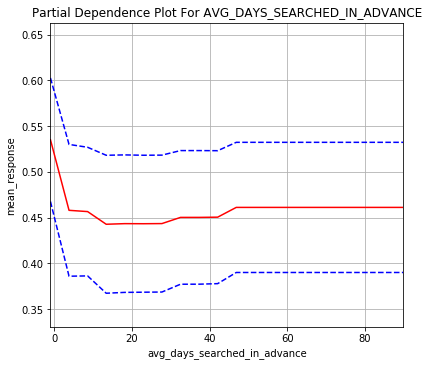

In [132]:
_ =model.partial_plot(new_train, cols=['AVG_DAYS_SEARCHED_IN_ADVANCE'], figsize=(6,5))